##### L'utilisation de la PredictionErrorDisplay nécessite au moins une version 1.2.1 de scikit-learn

In [1]:
!pip install -U --user scikit-learn 
!pip install lightgbm
!pip install catboost
!pip install shap
!pip install treeplot
!pip install pingouin
!pip install graphviz
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import missingno as msno
import warnings

import pingouin as pg
import scipy as sp
import shap
import graphviz
from scipy.stats import kstest
from lightgbm import LGBMRegressor,plot_importance,plot_metric,plot_tree
from catboost import CatBoostRegressor,Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (r2_score,mean_squared_error,mean_absolute_error,
                             mean_absolute_percentage_error,max_error,
                             median_absolute_error,PredictionErrorDisplay)
from sklearn.model_selection import cross_validate,GridSearchCV,train_test_split
from sklearn.feature_selection import SequentialFeatureSelector,RFE,SelectFromModel
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,MaxAbsScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn import set_config

set_config(display='diagram',print_changed_only=False)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth',None)

### Loading 

In [6]:
df=pd.read_csv("../train.csv",index_col="Id",dtype={'MSSubClass':'category',
                    'OverallQual': 'category','OverallCond':'category','YearBuilt':'category',
                    'YearRemodAdd':'category','YrSold':'category','MoSold':'category','GarageYrBlt':'category'})

In [7]:
df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                   
1          60       RL         65.0     8450   Pave   NaN      Reg   
2          20       RL         80.0     9600   Pave   NaN      Reg   
3          60       RL         68.0    11250   Pave   NaN      IR1   
4          70       RL         60.0     9550   Pave   NaN      IR1   
5          60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

   Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt  \
Id                                                                    
1        Norm     1Fam     2Story           7           5      2003   
2        Norm     1Fam     1Story           6           8      1976   
3        Norm     1Fam     2Story           7           5      2001   
4        Norm     1Fam     2Story           7           5      1915   
5        Norm     1Fam     2Story           8           5      2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                      
1          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2          1976     Gable  CompShg     MetalSd     MetalSd       None   
3          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
5          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                             
1        196.0        Gd        TA      PConc       Gd       TA           No   
2          0.0        TA        TA     CBlock       Gd       TA           Gd   
3        162.0        Gd        TA      PConc       Gd       TA           Mn   
4          0.0        TA        TA     BrkTil       TA       Gd           No   
5        350.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                             
1           GLQ         706          Unf           0        150          856   
2           ALQ         978          Unf           0        284         1262   
3           GLQ         486          Unf           0        434          920   
4           ALQ         216          Unf           0        540          756   
5           GLQ         655          Unf           0        490         1145   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                             
1     GasA        Ex          Y      SBrkr       856       854             0   
2     GasA        Ex          Y      SBrkr      1262         0             0   
3     GasA        Ex          Y      SBrkr       920       866             0   
4     GasA        Gd          Y      SBrkr       961       756             0   
5     GasA        Ex          Y      SBrkr      1145      1053             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                            
1        1710             1             0         2         1             3   
2        1262             0             1         2         0             3  

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   object  
 2   LotFrontage    1201 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   object  
 5   Alley          91 non-null     object  
 6   LotShape       1460 non-null   object  
 7   LandContour    1460 non-null   object  
 8   Utilities      1460 non-null   object  
 9   LotConfig      1460 non-null   object  
 10  LandSlope      1460 non-null   object  
 11  Neighborhood   1460 non-null   object  
 12  Condition1     1460 non-null   object  
 13  Condition2     1460 non-null   object  
 14  BldgType       1460 non-null   object  
 15  HouseStyle     1460 non-null   object  
 16  OverallQual    1460 non-null   category
 17  OverallCond    1460 non-null   ca

In [9]:
df.select_dtypes(include="object").columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [10]:
df[df.select_dtypes(include="object").columns]=df[df.select_dtypes(include="object").columns].astype('category')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   category
 2   LotFrontage    1201 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   category
 5   Alley          91 non-null     category
 6   LotShape       1460 non-null   category
 7   LandContour    1460 non-null   category
 8   Utilities      1460 non-null   category
 9   LotConfig      1460 non-null   category
 10  LandSlope      1460 non-null   category
 11  Neighborhood   1460 non-null   category
 12  Condition1     1460 non-null   category
 13  Condition2     1460 non-null   category
 14  BldgType       1460 non-null   category
 15  HouseStyle     1460 non-null   category
 16  OverallQual    1460 non-null   category
 17  OverallCond    1460 non-null   ca

In [12]:
df.describe()

LotFrontage        LotArea   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1201.000000    1460.000000  1452.000000  1460.000000  1460.000000   
mean     70.049958   10516.828082   103.685262   443.639726    46.549315   
std      24.284752    9981.264932   181.066207   456.098091   161.319273   
min      21.000000    1300.000000     0.000000     0.000000     0.000000   
25%      59.000000    7553.500000     0.000000     0.000000     0.000000   
50%      69.000000    9478.500000     0.000000   383.500000     0.000000   
75%      80.000000   11601.500000   166.000000   712.250000     0.000000   
max     313.000000  215245.000000  1600.000000  5644.000000  1474.000000   

         BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean    567.240411  1057.429452  1162.626712   346.992466      5.844521   
std     441.866955   438.705324   386.587738   436.528436     48.623081   
min       0.000000     0.000000   334.000000     0.000000      0.000000   
25%     223.000000   795.750000   882.000000     0.000000      0.000000   
50%     477.500000   991.500000  1087.000000     0.000000      0.000000   
75%     808.000000  1298.250000  1391.250000   728.000000      0.000000   
max    2336.000000  6110.000000  4692.000000  2065.000000    572.000000   

         GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  \
count  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean   1515.463699      0.425342      0.057534     1.565068     0.382877   
std     525.480383      0.518911      0.238753     0.550916     0.502885   
min     334.000000      0.000000      0.000000     0.000000     0.000000   
25%    1129.500000      0.000000      0.000000     1.000000     0.000000   
50%    1464.000000      0.000000      0.000000     2.000000     0.000000   
75%    1776.750000      1.000000      0.000000     2.000000     1.000000   
max    5642.000000      3.000000      2.000000     3.000000     2.000000   

       BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces   GarageCars  \
count   1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean       2.866438      1.046575      6.517808     0.613014     1.767123   
std        0.815778      0.220338      1.625393     0.644666     0.747315   
min        0.000000      0.000000      2.000000     0.000000     0.000000   
25%        2.000000      1.000000      5.000000     0.000000     1.000000   
50%        3.000000      1.000000      6.000000     1.000000     2.000000   
75%        3.000000      1.000000      7.000000     1.000000     2.000000   
max        8.000000      3.000000     14.000000     3.000000     4.000000   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    472.980137    94.244521    46.660274      21.954110     3.409589   
std     213.804841   125.338794    66.256028      61.119149    29.317331   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     334.500000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    25.000000       0.000000     0.000000   
75%     576.000000   168.000000    68.000000       0.000000     0.000000   
max    1418.000000   857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal      SalePrice  
count  1460.000000  1460.000000   1460.000000    1460.000000  
mean     15.060959     2.758904     43.489041  180921.195890  
std      55.757415    40.177307    496.123024   79442.502883  
min       0.000000     0.000000      0.000000   34900.000000  
25%       0.000000     0.000000      0.000000  129975.000000  
50%       0.000000     0.000000      0.000000  163000.000000  
75%       0.000000     0.000000      0.000000  214000.000000  
max     480.000000   738.000000  15500.000000  755000.000000

In [13]:
df.describe(include="category")

MSSubClass MSZoning Street Alley LotShape LandContour Utilities  \
count        1460     1460   1460    91     1460        1460      1460   
unique         15        5      2     2        4           4         2   
top            20       RL   Pave  Grvl      Reg         Lvl    AllPub   
freq          536     1151   1454    50      925        1311      1459   

       LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
count       1460      1460         1460       1460       1460     1460   
unique         5         3           25          9          8        5   
top       Inside       Gtl        NAmes       Norm       Norm     1Fam   
freq        1052      1382          225       1260       1445     1220   

       HouseStyle OverallQual OverallCond YearBuilt YearRemodAdd RoofStyle  \
count        1460        1460        1460      1460         1460      1460   
unique          8          10           9       112           61         6   
top        1Story           5           5      2006         1950     Gable   
freq          726         397         821        67          178      1141   

       RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond  \
count      1460        1460        1460       1452      1460      1460   
unique        8          15          16          4         4         5   
top     CompShg     VinylSd     VinylSd       None        TA        TA   
freq       1434         515         504        864       906      1282   

       Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  \
count        1460     1423     1423         1422         1423         1422   
unique          6        4        4            4            6            6   
top         PConc       TA       TA           No          Unf          Unf   
freq          647      649     1311          953          430         1256   

       Heating HeatingQC CentralAir Electrical KitchenQual Functional  \
count     1460      1460       1460       1459        1460       1460   
unique       6         5          2          5           4          7   
top       GasA        Ex          Y      SBrkr          TA        Typ   
freq      1428       741       1365       1334         735       1360   

       FireplaceQu GarageType GarageYrBlt GarageFinish GarageQual GarageCond  \
count          770       1379        1379         1379       1379       1379   
unique           5          6          97            3          5          5   
top             Gd     Attchd        2005          Unf         TA         TA   
freq           380        870          65          605       1311       1326   

       PavedDrive PoolQC  Fence MiscFeature MoSold YrSold SaleType  \
count        1460      7    281          54   1460   1460     1460   
unique          3      3      4           4     12      5        9   
top             Y     Gd  MnPrv        Shed      6   2009       WD   
freq         1340      3    157          49    253    338     1267   

       SaleCondition  
count           1460  
unique             6  
top           Normal  
freq            1198

In [14]:
df.duplicated().sum()

0

### Categorical variables

<AxesSubplot:>

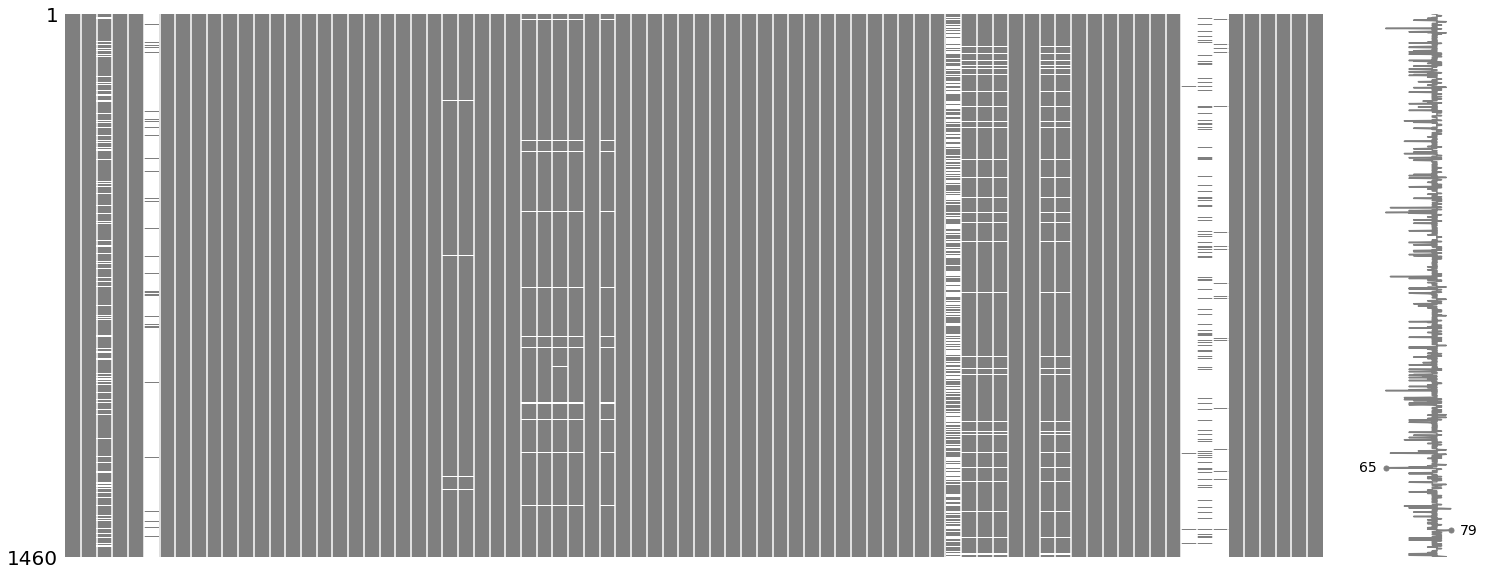

In [16]:
msno.matrix(df,color=(0.5,0.5,0.5))

In [17]:
df.isna().sum()[df.isna().any()]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [18]:
warnings.filterwarnings('ignore') # Turn off warnings
labels={'Alley':'No alley access',
        'BsmtQual':'No Basement',
        'BsmtCond':'No Basement',
        'BsmtExposure':'No Basement',
        'BsmtFinType1':'No Basement',
        'BsmtFinType2':'No Basement',
        'FireplaceQu':'No Fireplace',
        'GarageType':'No Garage',
        'GarageFinish':'No Garage',
        'GarageQual':'No Garage',
        'GarageCond':'No Garage','PoolQC':'No Pool',
        'Fence':'No Fence',
        'MiscFeature':'None',
        'GarageYrBlt':'No Garage'}

for variable,label in labels.items():
    # Set a new category to the variable
    df[variable].cat.add_categories(label,inplace=True)
    
    #Replace all the NA's by the new category
    df[variable].where(df[variable].notna(),other=label,inplace=True)

<AxesSubplot:>

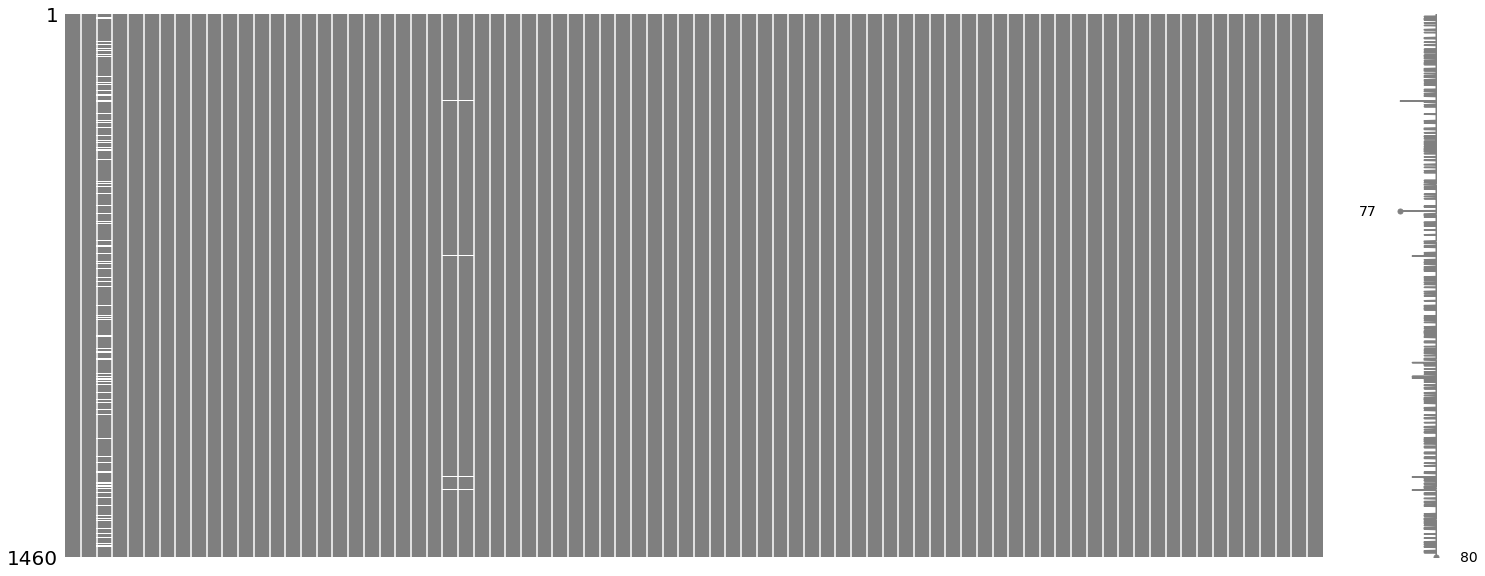

In [19]:
msno.matrix(df,color=(0.5,0.5,0.5))

In [20]:
df.isna().sum()[df.isna().any()]

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
dtype: int64

In [21]:
labels={'LandContour':['Lvl','Bnk','HLS','Low'],
        'Utilities':['ELO','NoSeWa','NoSeWr','AllPub'],
        'LandSlope':['Gtl','Mod','Sev'],
        'LotShape':['Reg','IR1','IR2','IR3'],
        'HouseStyle':['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl'],
        'OverallQual':['1','2','3','4','5','6','7','8','9','10'],'OverallCond':['1','2','3','4','5','6','7','8','9','10'],
        'ExterQual':['Po','Fa','TA','Gd','Ex'],
        'ExterCond':['Po','Fa','TA','Gd','Ex'],
        'BsmtQual':['No Basement','Po','Fa','TA','Gd','Ex'],
        'BsmtCond':['No Basement','Po','Fa','TA','Gd','Ex'],
        'BsmtExposure':['No Basement','No','Mn','Av','Gd'],
        'BsmtFinType1':['No Basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'BsmtFinType2':['No Basement','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'HeatingQC':['Po','Fa','TA','Gd','Ex'],
        'KitchenQual':['Po','Fa','TA','Gd','Ex'],
        'Functional':['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
        'FireplaceQu':['No Fireplace','Po','Fa','TA','Gd','Ex'],
        'GarageQual':['No Garage','Po','Fa','TA','Gd','Ex'],
        'GarageFinish':['No Garage','Unf','RFn','Fin'],
        'GarageCond':['No Garage','Po','Fa','TA','Gd','Ex'],
        'PavedDrive':['N','P','Y'],
        'PoolQC':['No Pool','Po','Fa','TA','Gd','Ex'],
        'Fence':['No Fence','MnWw','GdWo','MnPrv','GdPrv']
       }

for var_name,label in labels.items():
    for value in label:
        if value not in df[var_name].cat.categories:
            df[var_name].cat.add_categories(value,inplace=True)
        
    df[var_name].cat.reorder_categories(label,inplace=True)
    df[var_name].cat.as_ordered(inplace=True)

In [22]:
df.describe(include='category')

MSSubClass MSZoning Street            Alley LotShape LandContour  \
count        1460     1460   1460             1460     1460        1460   
unique         15        5      2                3        4           4   
top            20       RL   Pave  No alley access      Reg         Lvl   
freq          536     1151   1454             1369      925        1311   

       Utilities LotConfig LandSlope Neighborhood Condition1 Condition2  \
count       1460      1460      1460         1460       1460       1460   
unique         2         5         3           25          9          8   
top       AllPub    Inside       Gtl        NAmes       Norm       Norm   
freq        1459      1052      1382          225       1260       1445   

       BldgType HouseStyle OverallQual OverallCond YearBuilt YearRemodAdd  \
count      1460       1460        1460        1460      1460         1460   
unique        5          8          10           9       112           61   
top        1Fam     1Story           5           5      2006         1950   
freq       1220        726         397         821        67          178   

       RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual  \
count       1460     1460        1460        1460       1452      1460   
unique         6        8          15          16          4         4   
top        Gable  CompShg     VinylSd     VinylSd       None        TA   
freq        1141     1434         515         504        864       906   

       ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
count       1460       1460     1460     1460         1460         1460   
unique         5          6        5        5            5            7   
top           TA      PConc       TA       TA           No          Unf   
freq        1282        647      649     1311          953          430   

       BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual  \
count          1460    1460      1460       1460       1459        1460   
unique            7       6         5          2          5           4   
top             Unf    GasA        Ex          Y      SBrkr          TA   
freq           1256    1428       741       1365       1334         735   

       Functional   FireplaceQu GarageType GarageYrBlt GarageFinish  \
count        1460          1460       1460        1460         1460   
unique          7             6          7          98            4   
top           Typ  No Fireplace     Attchd   No Garage          Unf   
freq         1360           690        870          81          605   

       GarageQual GarageCond PavedDrive   PoolQC     Fence MiscFeature MoSold  \
count        1460       1460       1460     1460      1460        1460   1460   
unique          6          6          3        4         5           5     12   
top            TA         TA          Y  No Pool  No Fence        None      6   
freq         1311       1326       1340     1453      1179        1406    253   

       YrSold SaleType SaleCondition  
count    1460     1460          1460  
unique      5        9             6  
top      2009       WD        Normal  
freq      338     1267          1198

In [23]:
df[['MasVnrType','MasVnrArea']].groupby('MasVnrType').describe()

MasVnrArea                                                      \
                count        mean         std   min    25%    50%     75%   
MasVnrType                                                                  
BrkCmn           15.0  247.666667  182.423239  41.0   91.5  192.0  381.50   
BrkFace         445.0  259.008989  215.137888   0.0  114.0  202.0  336.00   
None            864.0    1.094907   18.569659   0.0    0.0    0.0    0.00   
Stone           128.0  239.304688  172.129257   0.0  111.5  206.5  296.25   

                    
               max  
MasVnrType          
BrkCmn       621.0  
BrkFace     1600.0  
None         344.0  
Stone        860.0

In [24]:
df[['BsmtFinType1','BsmtFinSF1']].groupby('BsmtFinType1',dropna=False).describe()

BsmtFinSF1                                                \
                  count        mean         std    min     25%    50%   
BsmtFinType1                                                            
No Basement        37.0    0.000000    0.000000    0.0    0.00    0.0   
Unf               430.0    0.000000    0.000000    0.0    0.00    0.0   
LwQ                74.0  379.540541  269.696236   16.0  187.00  318.0   
Rec               133.0  516.601504  272.460866  129.0  312.00  456.0   
BLQ               148.0  536.668919  270.945193   25.0  349.50  516.5   
ALQ               220.0  619.863636  320.433310   20.0  383.25  593.5   
GLQ               418.0  801.729665  490.888087    2.0  517.00  739.5   

                               
                  75%     max  
BsmtFinType1                   
No Basement      0.00     0.0  
Unf              0.00     0.0  
LwQ            503.00  1237.0  
Rec            637.00  1332.0  
BLQ            675.00  1277.0  
ALQ            788.25  1880.0  
GLQ           1081.25  5644.0

In [25]:
df[['BsmtFinType2','BsmtFinSF2']].groupby('BsmtFinType2',dropna=False).describe()

BsmtFinSF2                                                      \
                  count        mean         std   min    25%    50%     75%   
BsmtFinType2                                                                  
No Basement        38.0   12.605263   77.704061   0.0    0.0    0.0    0.00   
Unf              1256.0    0.000000    0.000000   0.0    0.0    0.0    0.00   
LwQ                46.0  310.739130  200.198394  35.0  169.5  277.5  437.25   
Rec                54.0  392.462963  274.344276  64.0  180.0  320.0  498.75   
BLQ                33.0  329.909091  240.181229  28.0  147.0  294.0  441.00   
ALQ                19.0  626.157895  328.279736  64.0  539.0  606.0  702.00   
GLQ                14.0  658.000000  335.447806  41.0  507.0  623.0  939.25   

                      
                 max  
BsmtFinType2          
No Basement    479.0  
Unf              0.0  
LwQ           1061.0  
Rec           1085.0  
BLQ           1120.0  
ALQ           1474.0  
GLQ           1127.0

### Data Preparation

In [26]:
print((df[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']].sum(axis=1)==df['TotalBsmtSF']).value_counts())
print((df[['1stFlrSF','2ndFlrSF','LowQualFinSF']].sum(axis=1)==df['GrLivArea']).value_counts())

True    1460
dtype: int64
True    1460
dtype: int64


In [27]:
df=df.drop(columns='BsmtUnfSF')
for part in ['BsmtFinSF1','BsmtFinSF2']:
    df[part]=100*df[part]/df['TotalBsmtSF']

df['BsmtFinSF1'].fillna(0,inplace=True)
df['BsmtFinSF2'].fillna(0,inplace=True)

df=df.drop(columns='LowQualFinSF')
for part in ['1stFlrSF','2ndFlrSF']:
    df[part]=100*df[part]/df['GrLivArea']

df['YearBuilt']=df['YrSold'].astype('int')-df['YearBuilt'].astype('int')
df['YearRemodAdd']=df['YrSold'].astype('int')-df['YearRemodAdd'].astype('int')
df['GarageYrBlt'].replace(to_replace='No Garage',value=0,inplace=True)
df['GarageYrBlt']=df['YrSold'].astype('int')-df['GarageYrBlt'].astype('int')
df['GarageYrBlt'][df['GarageYrBlt']>=2006]=df['GarageYrBlt'][df['GarageYrBlt']<2006].max()

In [28]:
metrics=[r2_score,mean_squared_error,mean_absolute_error,max_error,
         median_absolute_error,mean_absolute_percentage_error,]

def get_performance(train_real_value,train_estimated_value,test_real_value=None,
                    test_estimated_value=None,metrics=metrics):
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(train_real_value,train_estimated_value))
        test_perfs.append(metric_func(test_real_value,test_estimated_value))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    """
    Plot the train's prediction and real value: make a comparison
    """
    fig,ax=plt.subplots(ncols=4,figsize=(16,4))
    PredictionErrorDisplay.from_predictions(train_real_value,train_estimated_value,
                                            kind='actual_vs_predicted',ax=ax[0])
    ax[0].set_title('Valeurs réelles vs. predictions')
    PredictionErrorDisplay.from_predictions(train_real_value,train_estimated_value,
                                            kind='residual_vs_predicted',ax=ax[1])
    ax[1].set_title('Valeurs résiduelles vs. predictions')
    fig.suptitle('Train set')
    
    """
    Plot the test's prediction and real value: make a comparison
    """
    if test_real_value is not None and test_estimated_value is not None:
        PredictionErrorDisplay.from_predictions(test_real_value,test_estimated_value,
                                                scatter_kwargs={'color':'orange'},
                                                kind='actual_vs_predicted',ax=ax[2])
        ax[2].set_title('Valeurs réelles vs. predictions')
        PredictionErrorDisplay.from_predictions(test_real_value,test_estimated_value,
                                                scatter_kwargs={'color':'orange'},
                                                kind='residual_vs_predicted',ax=ax[3])
        ax[3].set_title('Valeurs résiduelles vs. predictions')
        fig.suptitle('Test set')

    return pd.DataFrame(perfs)

### Features selection

#### Filter methods

In [29]:
def filter_selector(filt=False,num_alpha=0.5,cat_alpha=0.05): 
    
    ordinal_features=list(labels.keys())
    if filt==True:
        """Numeric features selection
        """
        corr=df.corr()
        cor_target=abs(corr['SalePrice'])
        best_features=list((cor_target[cor_target>num_alpha].index).difference(['SalePrice']))

        print(best_features)
        
    """Categorical features selection
      """
    best_features=[]
    categorial_features=df.select_dtypes('category').columns
    tab=pd.DataFrame()

    for col_name in list(categorial_features):
        tab=pd.concat([tab,pg.anova(data=df,dv='SalePrice',between=col_name)],ignore_index=True)
    best_features.extend(list(tab[tab['p-unc']<cat_alpha]['Source']))
    best_features=pd.Index(best_features)

  

    intersection=[]
    ordinal_categories=[]
    for feature in ordinal_features:
        if feature in list(best_features):
            intersection.append(feature)
            ordinal_categories.append(labels.get(feature))
    ordinal_features=intersection
    return best_features,ordinal_features,ordinal_categories
      


In [30]:
best_features,ordinal_features,ordinal_categories=filter_selector(filt=False)
nominal_features=df[best_features].select_dtypes('category').columns.difference(ordinal_features)

In [31]:
best_features=best_features.append(df.select_dtypes('number').columns)

In [32]:
print(best_features)

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'LotFrontage',
       'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'Wood

In [43]:
X_train.select_dtypes("number").columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SalePrice'],
      dtype='object')

In [33]:
X,y=df[best_features.difference(['SalePrice'])],np.log(df['SalePrice'])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [35]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1168, 72), (1168,), (292, 72), (292,))

In [36]:
ordinal_categories

[['Lvl', 'Bnk', 'HLS', 'Low'],
 ['Reg', 'IR1', 'IR2', 'IR3'],
 ['1Story',
  '1.5Fin',
  '1.5Unf',
  '2Story',
  '2.5Fin',
  '2.5Unf',
  'SFoyer',
  'SLvl'],
 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['No Basement', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['No Basement', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['No Basement', 'No', 'Mn', 'Av', 'Gd'],
 ['No Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['No Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
 ['No Fireplace', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['No Garage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['No Garage', 'Unf', 'RFn', 'Fin'],
 ['No Garage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['N', 'P', 'Y'],
 ['No Pool', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['No Fence', 'MnWw', 'GdWo', 'MnPrv', 'Gd

In [37]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                      ("scaler", MinMaxScaler())]
                                  )

categorical_transformer = Pipeline(steps=[("imputer",SimpleImputer(strategy="constant", fill_value="missing")),
                                          ("OHE",OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False))]
                                    )
ordinal_transformer = Pipeline(steps=[('imputer2',SimpleImputer(strategy="constant")),
                                          ('ORD_ENC',OrdinalEncoder(categories=ordinal_categories,handle_unknown='error'))]
)
preprocessor=ColumnTransformer(
    transformers=[
            ('numerical',numeric_transformer,make_column_selector(dtype_include='number')),
            ('nominal',categorical_transformer,nominal_features),
            ('ordinal',ordinal_transformer,ordinal_features)
    ]
)

### Principal Components Regression -PCR

In [38]:
len(ordinal_features)

22

In [39]:
X_train.shape

(1168, 72)

In [40]:
pcr=Pipeline(
    steps=[('preprocessor',preprocessor),('PCA',PCA(n_components=94)),('regression',LinearRegression())]
)
pcr

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  (...
                                                   'PavedDrive', 'PoolQC',
                                                   'Fence'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=94,
                     n_oversamples=10, power_iteration_normalizer='auto',
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  positive=False))],
         verbose=False)

In [41]:
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('numerical',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                keep_empty_features=False,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose='deprecated')),
                                                 ('scaler',
                                                  MinMaxScaler(clip=False,
                                                               copy=True,
                                                               f...
                                                                 unknown_value=None))],
                                          verbose=False),
                                 ['LandContour', 'LotShape', 'HouseStyle',
                                  'OverallQual', 'OverallCond', 'ExterQual',
                                  'ExterCond', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                                  'Functional', 'FireplaceQu', 'GarageQual',
                                  'GarageFinish', 'GarageCond', 'PavedDrive',
                                  'PoolQC', 'Fence'])],
                  verbose=False, verbose_feature_names_out=True)

In [42]:
pcr.named_steps['preprocessor'].named_transformers_['ordinal'].named_steps['ORD_ENC'].categories_

[array(['Lvl', 'Bnk', 'HLS', 'Low'], dtype=object),
 array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object),
 array(['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf',
        'SFoyer', 'SLvl'], dtype=object),
 array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype=object),
 array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype=object),
 array(['Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=object),
 array(['Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=object),
 array(['No Basement', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=object),
 array(['No Basement', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=object),
 array(['No Basement', 'No', 'Mn', 'Av', 'Gd'], dtype=object),
 array(['No Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
       dtype=object),
 array(['No Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
       dtype=object),
 array(['Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=object),
 array(['Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype=object),
 array(['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod'

In [43]:
pcr.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  (...
                                                   'PavedDrive', 'PoolQC',
                                                   'Fence'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=94,
                     n_oversamples=10, power_iteration_normalizer='auto',
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  positive=False))],
         verbose=False)

In [44]:
pcr['preprocessor'].named_transformers_['ordinal']

Pipeline(memory=None,
         steps=[('imputer2',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               keep_empty_features=False, missing_values=nan,
                               strategy='constant', verbose='deprecated')),
                ('ORD_ENC',
                 OrdinalEncoder(categories=[['Lvl', 'Bnk', 'HLS', 'Low'],
                                            ['Reg', 'IR1', 'IR2', 'IR3'],
                                            ['1Story', '1.5Fin', '1.5Unf',
                                             '2Story', '2.5Fin', '2.5Unf',
                                             'SFoyer', 'SLvl'],...
                                            ['No Fireplace', 'Po', 'Fa', 'TA',
                                             'Gd', 'Ex'],
                                            ['No Garage', 'Po', 'Fa', 'TA',
                                             'Gd', 'Ex'],
                                            ['No Garage', 'Unf', 'RFn', 'Fin'],
                                            ['No Garage', 'Po', 'Fa', 'TA',
                                             'Gd', 'Ex'],
                                            ['N', 'P', 'Y'],
                                            ['No Pool', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['No Fence', 'MnWw', 'GdWo',
                                             'MnPrv', 'GdPrv']],
                                dtype=<class 'numpy.float64'>,
                                encoded_missing_value=nan,
                                handle_unknown='error', unknown_value=None))],
         verbose=False)

In [45]:
pcr['PCA'].n_components_,pcr['PCA'].n_features_in_

(94, 196)

In [46]:
pca_variance=pcr['PCA'].explained_variance_ratio_[:30]

Text(0, 0.5, 'Variance ratio')

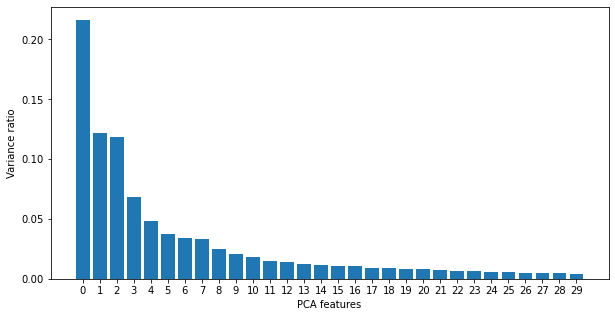

In [47]:
plt.figure(figsize=(10,5))
plt.bar(range(30),pca_variance)
plt.xlabel('PCA features')
plt.xticks(range(30))
plt.ylabel('Variance ratio')

metric     train      test
0                        r2_score  0.903447  0.870756
1              mean_squared_error  0.015316  0.021025
2             mean_absolute_error  0.087143  0.100724
3                       max_error  1.103858  0.858497
4           median_absolute_error  0.065313  0.072460
5  mean_absolute_percentage_error  0.007291  0.008406

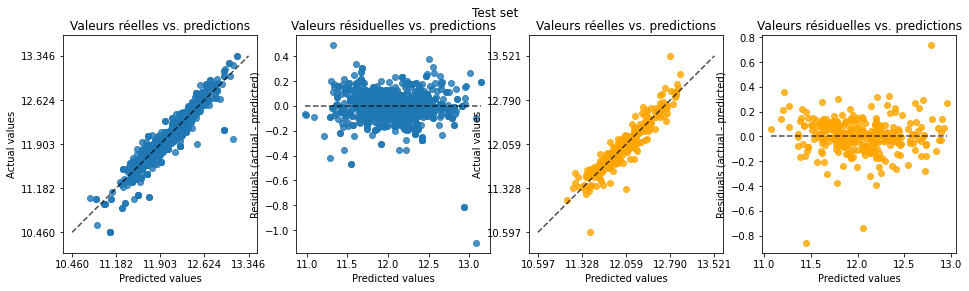

In [48]:
y_train_pred=pcr.predict(X_train).squeeze()
y_test_pred=pcr.predict(X_test).squeeze()
get_performance(y_train,y_train_pred,y_test,y_test_pred,metrics)

In [49]:
cv_results=cross_validate(pcr,X_train,y_train,cv=5,
                          scoring=('r2','neg_mean_squared_error'),
                          error_score='raise',return_train_score=True)
pd.DataFrame(cv_results)

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.447063    0.034685  0.876475  0.904795                    -0.024046   
1  0.140615    0.031249  0.890690  0.902220                    -0.015187   
2  0.113441    0.046873  0.843898  0.915683                    -0.026812   
3  0.140615    0.046873  0.893786  0.901278                    -0.015645   
4  0.121082    0.031249  0.841690  0.909567                    -0.021782   

   train_neg_mean_squared_error  
0                     -0.014238  
1                     -0.015992  
2                     -0.013066  
3                     -0.015899  
4                     -0.014816

In [50]:
for score in ['r2','neg_mean_squared_error']:
    print(f"=={score}")
    for group in ['train','test']: 
        mean_score=cv_results[f"{group}_{score}"].mean()
        std_score=cv_results[f"{group}_{score}"].std()
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

==r2
train===================
 Mean score (std) 0.9067087784631104 (0.00532950214778418)

test===================
 Mean score (std) 0.8693079649035884 (0.022433044873779177)

==neg_mean_squared_error
train===================
 Mean score (std) -0.014802262725901991 (0.001091080873788264)

test===================
 Mean score (std) -0.020694336308608056 (0.00459712585186439)



#### Hyperparameters tuning

In [51]:
param_grid={'PCA__n_components':np.arange(start=60,stop=100,step=1),
           "preprocessor__numerical__imputer__strategy": ["mean", "median"]}
grid_search=GridSearchCV(pcr,param_grid,cv=5,scoring=('r2','neg_mean_squared_error'),
                         refit='neg_mean_squared_error',return_train_score=True)
grid_search

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        keep_empty_features=False,
                                                                                                        missing_values=na...
             param_grid={'PCA__n_components': array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99]),
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median']},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [52]:
grid_search.fit(X_train,y_train)


KeyboardInterrupt



In [492]:
best_params=grid_search.best_params_
print(f"Best params : {best_params}")

Best params : {'PCA__n_components': 94, 'preprocessor__numerical__imputer__strategy': 'mean'}


In [232]:
grid_cv_results=grid_search.cv_results_
best_param_index=np.where(grid_cv_results['rank_test_neg_mean_squared_error']==1)[0][0]
for score in ['r2','neg_mean_squared_error']:
    print (f"Best Scores: {score}")
    for group in ['train','test']:
        mean_score=grid_cv_results[f"mean_{group}_{score}"][best_param_index]
        std_score=grid_cv_results[f"std_{group}_{score}"][best_param_index]
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

Best Scores: r2
train===================
 Mean score (std) 0.9053071934067567 (0.0058144611197367855)

test===================
 Mean score (std) 0.8703509301603211 (0.03271939249869192)

Best Scores: neg_mean_squared_error
train===================
 Mean score (std) -0.015572408370632024 (0.0009060992536897731)

test===================
 Mean score (std) -0.021122309393587602 (0.004814747947255265)



#### Features Importance

In [58]:
def get_input_features(model_pipeline):
    
    """ Get model feature names used in training
    """
    all_feature_names = []

    for step_name, pipe_trans, feat_names in model_pipeline["preprocessor"].transformers_:
        if step_name == "nominal":
            all_feature_names.extend(pipe_trans
                                     .named_steps['OHE']
                                     .get_feature_names_out()
                                    )
        else:
            all_feature_names.extend(feat_names)
    return all_feature_names

In [59]:
model_features=get_input_features(pcr)

In [495]:
model_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'x0_No alley access',
 'x0_Pave',
 'x1_2fmCon',
 'x1_Duplex',
 'x1_Twnhs',
 'x1_TwnhsE',
 'x2_Y',
 'x3_Feedr',
 'x3_Norm',
 'x3_PosA',
 'x3_PosN',
 'x3_RRAe',
 'x3_RRAn',
 'x3_RRNe',
 'x3_RRNn',
 'x4_Feedr',
 'x4_Norm',
 'x4_PosA',
 'x4_PosN',
 'x4_RRAe',
 'x4_RRAn',
 'x4_RRNn',
 'x5_FuseF',
 'x5_FuseP',
 'x5_Mix',
 'x5_SBrkr',
 'x5_missing',
 'x6_AsphShn',
 'x6_BrkComm',
 'x6_BrkFace',
 'x6_CBlock',
 'x6_CemntBd',
 'x6_HdBoard',
 'x6_ImStucc',
 'x6_MetalSd',
 'x6_Plywood',
 'x6_Stone',
 'x6_Stucco',
 'x6_VinylSd',
 'x6_Wd Sdng',
 'x6_WdShing',
 'x7_AsphShn

Coefficient
86     0.197766
74     0.164777
58     0.157340
66     0.153761
89     0.151155
81     0.149280
87     0.132096
69     0.129212

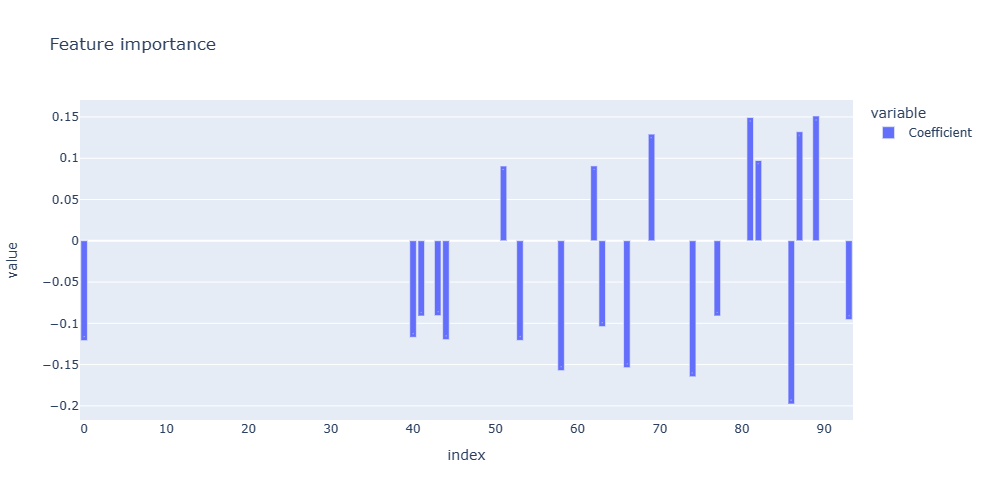

In [56]:
feature_importance=pd.DataFrame(pcr['regression'].coef_,columns=['Coefficient'])
"""
Plot feature importances
"""
feature_importance.abs()
display(feature_importance.abs().nlargest(8,'Coefficient') )
pd.options.plotting.backend = "plotly"
(feature_importance
    .sort_values('Coefficient',key=lambda v :abs(v),ascending=True)
    .tail(20)
    .plot.bar(title='Feature importance',text_auto='.2s',height=500)
    )

In [60]:
pca_transform=pd.DataFrame(PCA(n_components=94).fit_transform(pcr['preprocessor'].transform(X_train).T),index=model_features)

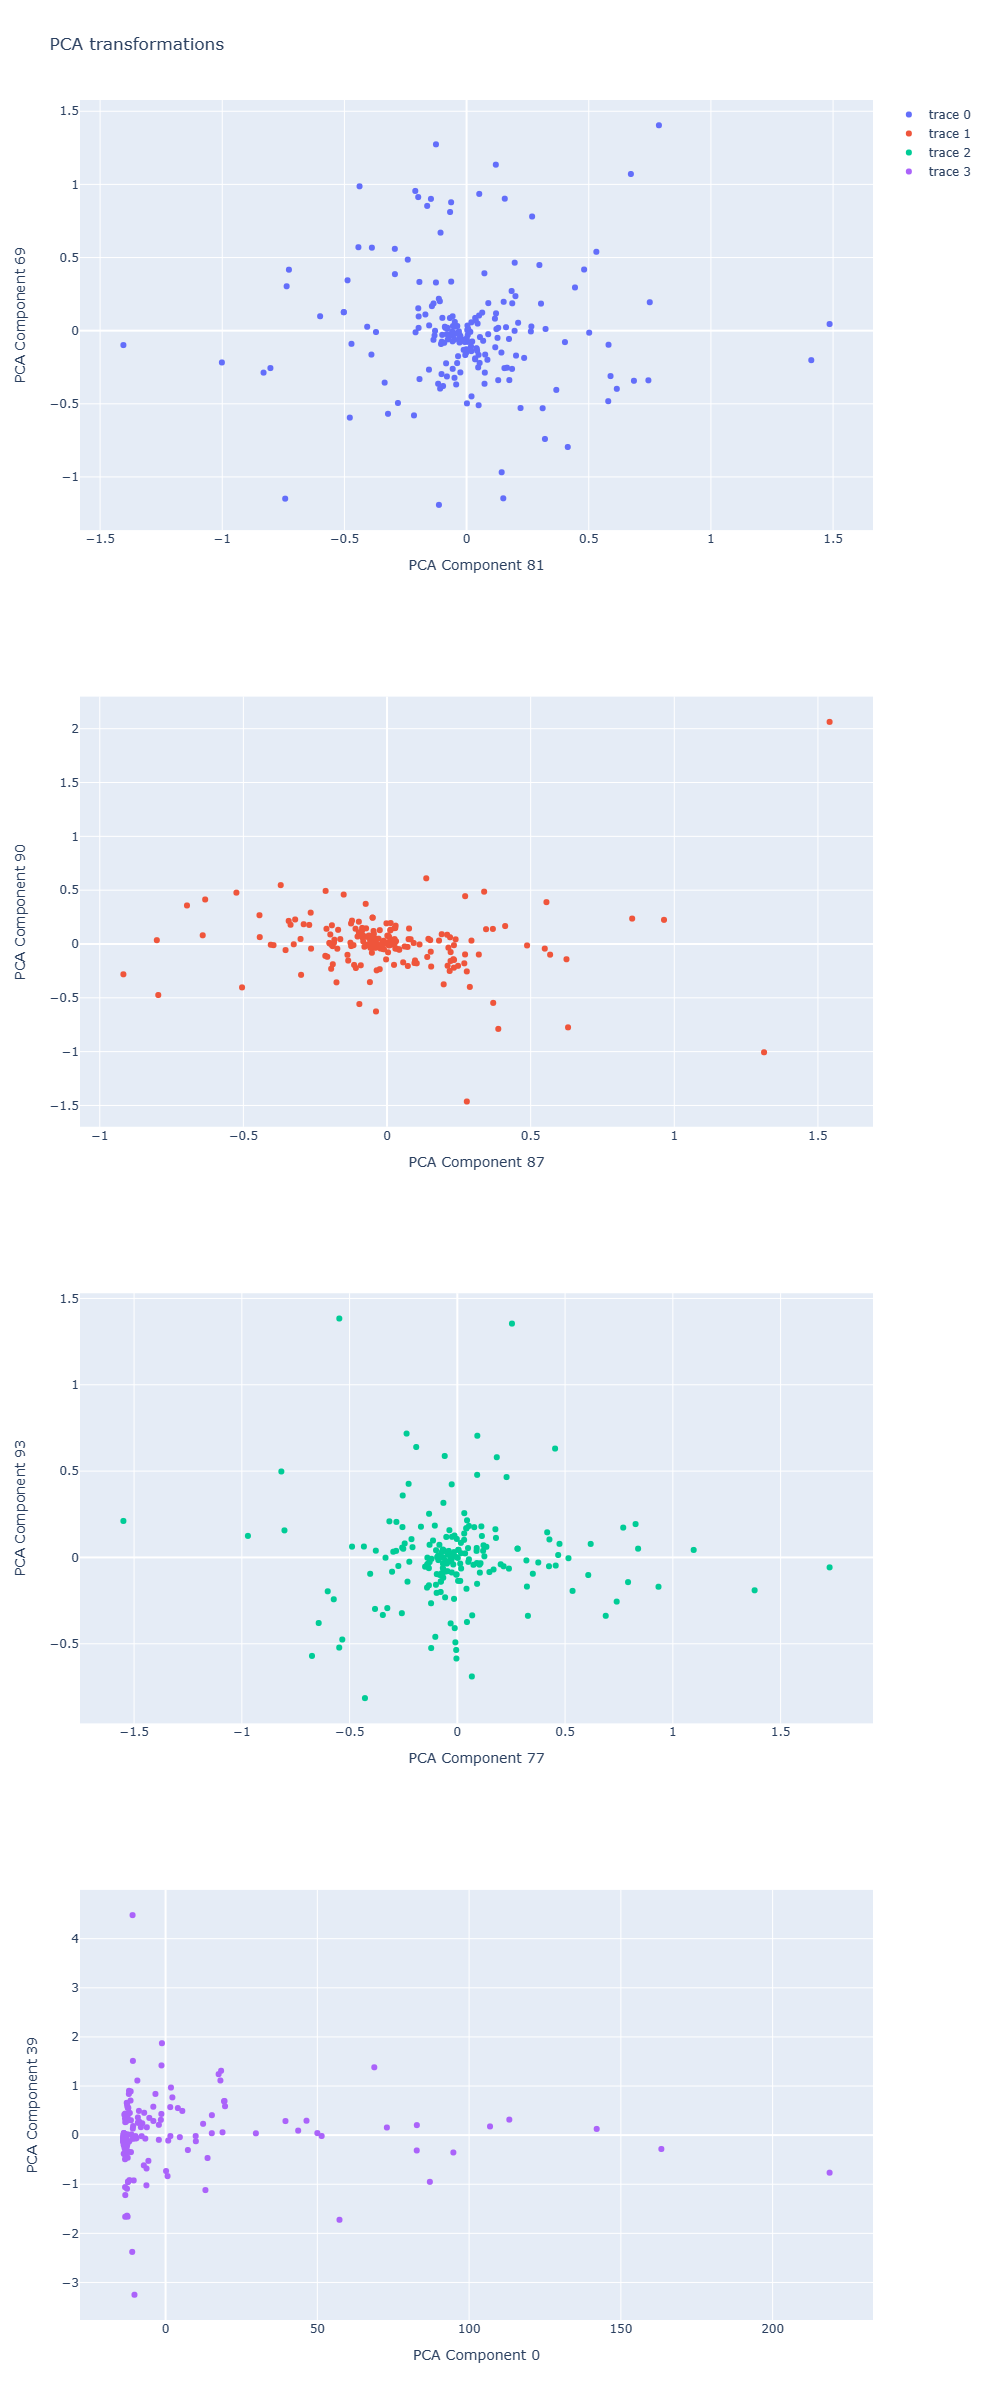

In [61]:
fig=make_subplots(rows=4,cols=1)
fig.append_trace(go.Scatter(x=pca_transform[81],y=pca_transform[69],hovertext=list(model_features),mode='markers'),row=1,col=1)
fig.append_trace(go.Scatter(x=pca_transform[87],y=pca_transform[90],hovertext=model_features,mode='markers'),row=2,col=1)
fig.append_trace(go.Scatter(x=pca_transform[77],y=pca_transform[93],hovertext=model_features,mode='markers'),row=3,col=1)
fig.append_trace(go.Scatter(x=pca_transform[0],y=pca_transform[39],hovertext=model_features,mode='markers'),row=4,col=1)

# Update xaxis properties
fig.update_xaxes(title_text="PCA Component 81", row=1, col=1)
fig.update_xaxes(title_text="PCA Component 87", row=2, col=1)
fig.update_xaxes(title_text="PCA Component 77", row=3, col=1)
fig.update_xaxes(title_text="PCA Component 0", row=4, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="PCA Component 69", row=1, col=1)
fig.update_yaxes(title_text="PCA Component 90", row=2, col=1)
fig.update_yaxes(title_text="PCA Component 93", row=3, col=1)
fig.update_yaxes(title_text="PCA Component 39", row=4, col=1)

fig.update_layout(height=2400, width=900, title_text="PCA transformations")
fig.show()

### Partial Least Square -PLS

In [62]:
pls=Pipeline(
    steps=[('preprocessor',preprocessor),('PLS',PLSRegression(n_components=3))]
)
pls

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  (...
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu', 'GarageQual',
                                                   'GarageFinish', 'GarageCond',
                                                   'PavedDrive', 'PoolQC',
                                                   'Fence'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('PLS',
                 PLSRegression(copy=True, max_iter=500, n_components=3,
                               scale=True, tol=1e-06))],
         verbose=False)

In [63]:
pls_features=pls.fit_transform(X_train,y_train)

In [64]:
pls_features

(array([[-0.51441579, -0.57236251, -0.42124059],
        [ 3.65706351, -1.1331388 ,  2.03493852],
        [-3.51932643,  1.16306436, -0.4125398 ],
        ...,
        [ 0.28670788, -2.99197475,  1.1058464 ],
        [ 0.1878776 , -0.33662247,  1.93900824],
        [-3.58216709, -0.42157392,  0.03743693]]),
 array([[-0.9997451 , -0.55725237,  0.41059101],
        [ 2.78319404,  1.55133692, -1.14304581],
        [-1.24444062, -0.6936443 ,  0.5110864 ],
        ...,
        [-1.79349396, -0.99968358,  0.73658024],
        [-0.77759101, -0.43342492,  0.31935328],
        [-2.16633514, -1.20750319,  0.88970451]]))

In [65]:
pls.score(X_train,y_train)

0.9022457591480744

In [66]:
pls.named_steps['PLS'].y_weights_

array([[ 0.23339379,  0.13009241, -0.09585383]])

metric     train      test
0                        r2_score  0.902246  0.866864
1              mean_squared_error  0.015506  0.021658
2             mean_absolute_error  0.085668  0.103390
3                       max_error  1.356380  1.004556
4           median_absolute_error  0.061982  0.078730
5  mean_absolute_percentage_error  0.007173  0.008628

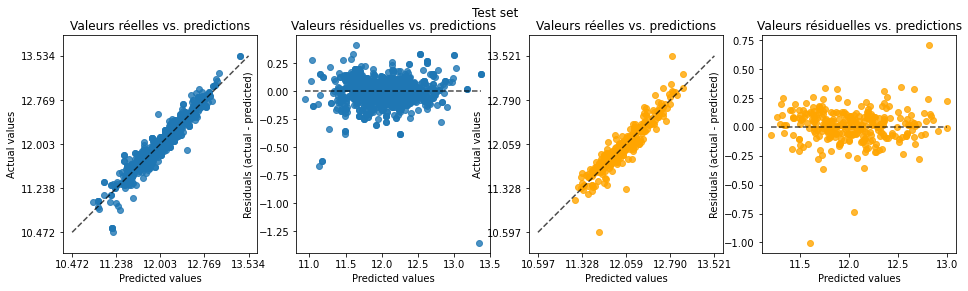

In [67]:
y_train_pred=pls.predict(X_train).squeeze()
y_test_pred=pls.predict(X_test).squeeze()
get_performance(y_train,y_train_pred,y_test,y_test_pred,metrics)

In [68]:
cv_results=cross_validate(pls,X_train,y_train,cv=5,
                          scoring=('r2','neg_mean_squared_error'),
                          error_score='raise',return_train_score=True)
pd.DataFrame(cv_results)

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.299829    0.040459  0.875304  0.903012                    -0.024274   
1  0.111817    0.031248  0.885652  0.902289                    -0.015887   
2  0.124988    0.046872  0.801575  0.917071                    -0.034081   
3  0.108648    0.053095  0.888428  0.900765                    -0.016434   
4  0.150404    0.035038  0.839521  0.908495                    -0.022081   

   train_neg_mean_squared_error  
0                     -0.014505  
1                     -0.015981  
2                     -0.012851  
3                     -0.015981  
4                     -0.014992

In [69]:
for score in ['r2','neg_mean_squared_error']:
    print(f"=={score}")
    for group in ['train','test']: 
        mean_score=cv_results[f"{group}_{score}"].mean()
        std_score=cv_results[f"{group}_{score}"].std()
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

==r2
train===================
 Mean score (std) 0.9063263572883686 (0.005972682017116478)

test===================
 Mean score (std) 0.8580959910407515 (0.0332118256799203)

==neg_mean_squared_error
train===================
 Mean score (std) -0.014862002712613393 (0.0011571198398333963)

test===================
 Mean score (std) -0.02255133962861284 (0.006602391743948572)



#### Hyperparamaters tuning 

In [319]:
param_grid={'PLS__n_components':np.arange(start=2,stop=15,step=1),
            "preprocessor__numerical__scaler":[StandardScaler(),MinMaxScaler()],
           "preprocessor__numerical__imputer__strategy": ["mean", "median"]}
grid_search=GridSearchCV(pls,param_grid,cv=5,scoring=('r2','neg_mean_squared_error'),
                         refit='neg_mean_squared_error',return_train_score=True)
grid_search

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        keep_empty_features=False,
                                                                                                        missing_values=na...
             param_grid={'PLS__n_components': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median'],
                         'preprocessor__numerical__scaler': [StandardScaler(copy=True,
                                                                            with_mean=True,
                                                                            with_std=True),
                                                             MinMaxScaler(clip=False,
                                                                          copy=True,
                                                                          feature_range=(0,
                                                                                         1))]},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [320]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        keep_empty_features=False,
                                                                                                        missing_values=na...
             param_grid={'PLS__n_components': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median'],
                         'preprocessor__numerical__scaler': [StandardScaler(copy=True,
                                                                            with_mean=True,
                                                                            with_std=True),
                                                             MinMaxScaler(clip=False,
                                                                          copy=True,
                                                                          feature_range=(0,
                                                                                         1))]},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [322]:
best_params=grid_search.best_params_
print(f"Best params : {best_params}")

Best params : {'PLS__n_components': 3, 'preprocessor__numerical__imputer__strategy': 'median', 'preprocessor__numerical__scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [323]:
grid_cv_results=grid_search.cv_results_
best_param_index=np.where(grid_cv_results['rank_test_neg_mean_squared_error']==1)[0][0]
for score in ['r2','neg_mean_squared_error']:
    print (f"Best Scores: {score}")
    for group in ['train','test']:
        mean_score=grid_cv_results[f"mean_{group}_{score}"][best_param_index]
        std_score=grid_cv_results[f"std_{group}_{score}"][best_param_index]
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

Best Scores: r2
train===================
 Mean score (std) 0.9058370946637909 (0.004976113529255477)

test===================
 Mean score (std) 0.854599361072701 (0.03704851498868084)

Best Scores: neg_mean_squared_error
train===================
 Mean score (std) -0.015485263271450955 (0.000755479907675124)

test===================
 Mean score (std) -0.02371600345801808 (0.005606459355079573)



#### Features importance

In [70]:
def get_input_features(model_pipeline):
    
    """ Get model feature names used in training
    """
    all_feature_names = []

    for step_name, pipe_trans, feat_names in model_pipeline["preprocessor"].transformers_:
        if step_name == "nominal":
            all_feature_names.extend(pipe_trans
                                     .named_steps['OHE']
                                     .get_feature_names_out()
                                    )
        else:
            all_feature_names.extend(feat_names)
    return all_feature_names

In [71]:
model_features=get_input_features(pls)
model_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'x0_No alley access',
 'x0_Pave',
 'x1_2fmCon',
 'x1_Duplex',
 'x1_Twnhs',
 'x1_TwnhsE',
 'x2_Y',
 'x3_Feedr',
 'x3_Norm',
 'x3_PosA',
 'x3_PosN',
 'x3_RRAe',
 'x3_RRAn',
 'x3_RRNe',
 'x3_RRNn',
 'x4_Feedr',
 'x4_Norm',
 'x4_PosA',
 'x4_PosN',
 'x4_RRAe',
 'x4_RRAn',
 'x4_RRNn',
 'x5_FuseF',
 'x5_FuseP',
 'x5_Mix',
 'x5_SBrkr',
 'x5_missing',
 'x6_AsphShn',
 'x6_BrkComm',
 'x6_BrkFace',
 'x6_CemntBd',
 'x6_HdBoard',
 'x6_ImStucc',
 'x6_MetalSd',
 'x6_Plywood',
 'x6_Stone',
 'x6_Stucco',
 'x6_VinylSd',
 'x6_Wd Sdng',
 'x6_WdShing',
 'x7_AsphShn',
 'x7_Brk Cm

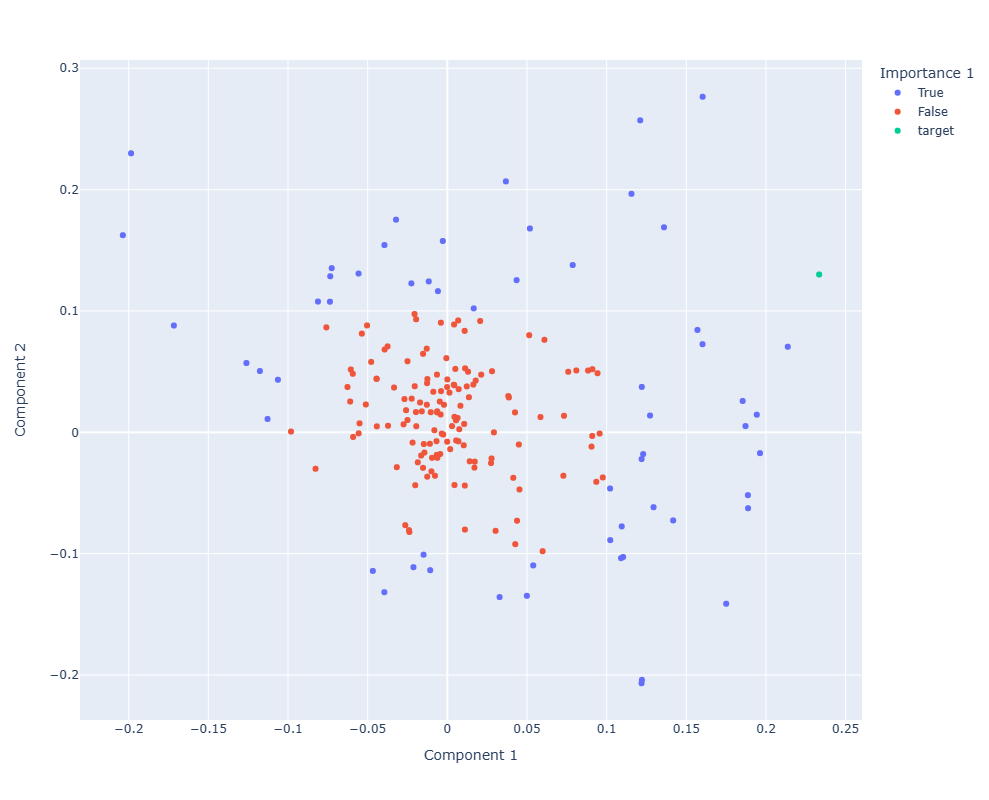

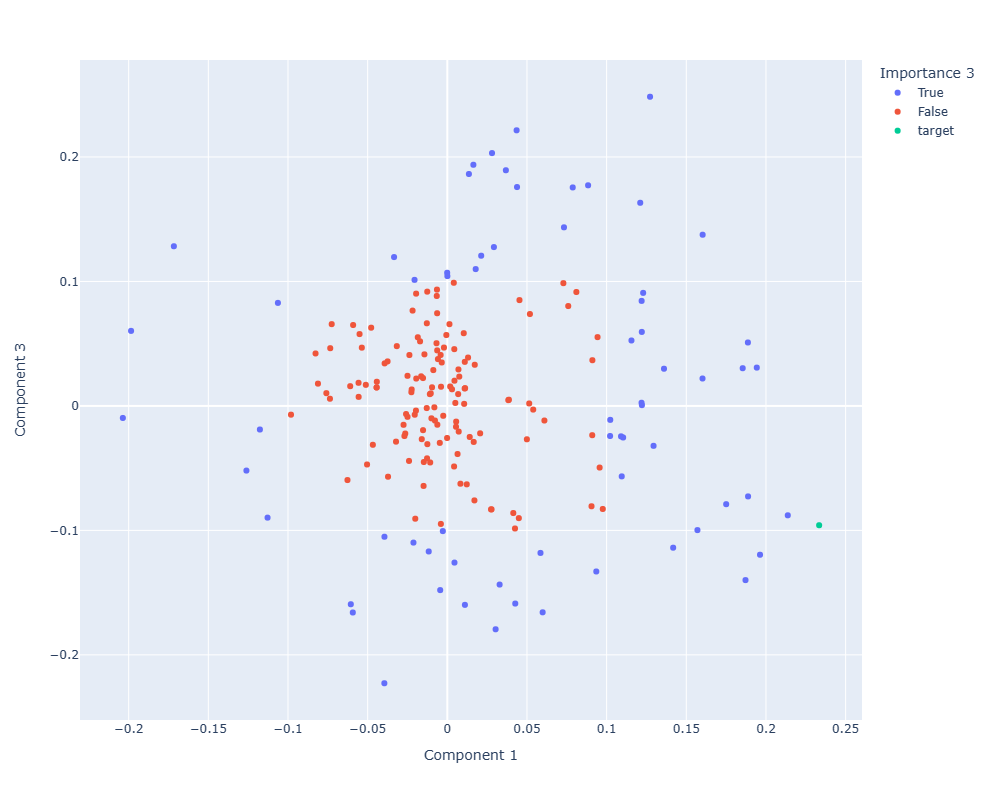

In [72]:
columns=['Component 1','Component 2','Component 3']
X_loadings=pd.DataFrame(pls['PLS'].x_loadings_,columns=columns,index=model_features)
y_loadings=pd.DataFrame(pls['PLS'].y_loadings_,columns=columns,index=['SalePrice'])

X_loadings['Importance 1']=((abs(X_loadings[['Component 1','Component 2']])).max(axis=1)>0.1)
X_loadings['Importance 3']=((abs(X_loadings[['Component 1','Component 3']])).max(axis=1)>0.1)
y_loadings['Importance 1'],y_loadings['Importance 3']='target','target'

data_loadings=pd.concat([X_loadings,y_loadings])

display(px.scatter(data_loadings,x='Component 1',y='Component 2',height=800,width=800,
                   hover_name=data_loadings.index,color='Importance 1'))

display(px.scatter(data_loadings,x='Component 1',y='Component 3',height=800,width=800,
                   hover_name=data_loadings.index,color='Importance 3'))

Importance
OverallQual     0.039247
GrLivArea       0.035199
TotRmsAbvGrd    0.026424
KitchenQual     0.026117
TotalBsmtSF     0.025113
FullBath        0.024546
FireplaceQu     0.022562
ExterQual       0.021980

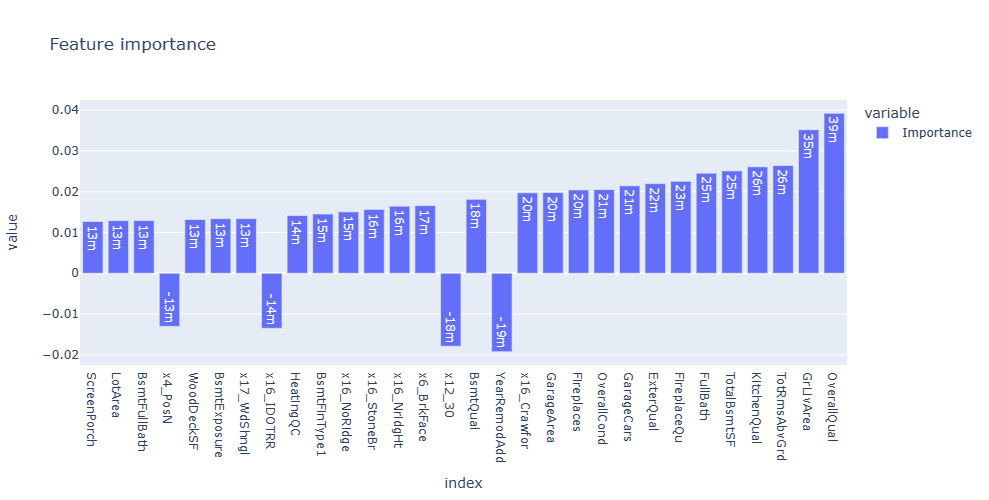

In [73]:
feature_importance=pd.DataFrame(pls['PLS'].coef_,index=model_features,columns=['Importance'])
"""
Plot feature importances
"""
display(feature_importance.nlargest(8,'Importance'))
pd.options.plotting.backend = "plotly"
(feature_importance
    .sort_values('Importance',key=lambda v :abs(v),ascending=True)
    .tail(30)
    .plot.bar(title='Feature importance',text_auto='.2s',height=500)
    )

### Gradient Boosting

In [74]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                      ("scaler", StandardScaler())]
                                  )

categorical_transformer = Pipeline(steps=[("imputer",SimpleImputer(strategy="constant", fill_value="missing")),
                                          ("OHE",OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False))]
                                    )
ordinal_transformer = Pipeline(steps=[('imputer2',SimpleImputer(strategy="constant")),
                                          ('ORD_ENC',OrdinalEncoder(categories=ordinal_categories,handle_unknown='error'))]
)
preprocessor=ColumnTransformer(
    transformers=[
            ('numerical',numeric_transformer,make_column_selector(dtype_include='number')),
            ('nominal',categorical_transformer,nominal_features),
            ('ordinal',ordinal_transformer,ordinal_features)
    ]
)

In [75]:
GBoost=Pipeline(
    steps=[('preprocessor',preprocessor),('GBOOST',GradientBoostingRegressor(n_estimators=278))]
     )
GBoost

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  (...
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1,
                                           loss='squared_error', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=278,
                                           n_iter_no_change=None,
                                           random_state=None, subsample=1.0,
                                           tol=0.0001, validation_fraction=0.1,
                                           verbose=0, warm_start=False))],
         verbose=False)

In [76]:
GBoost.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  (...
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1,
                                           loss='squared_error', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=278,
                                           n_iter_no_change=None,
                                           random_state=None, subsample=1.0,
                                           tol=0.0001, validation_fraction=0.1,
                                           verbose=0, warm_start=False))],
         verbose=False)

metric     train      test
0                        r2_score  0.982660  0.902221
1              mean_squared_error  0.002853  0.013580
2             mean_absolute_error  0.040941  0.080623
3                       max_error  0.282709  0.742268
4           median_absolute_error  0.032360  0.060312
5  mean_absolute_percentage_error  0.003419  0.006728

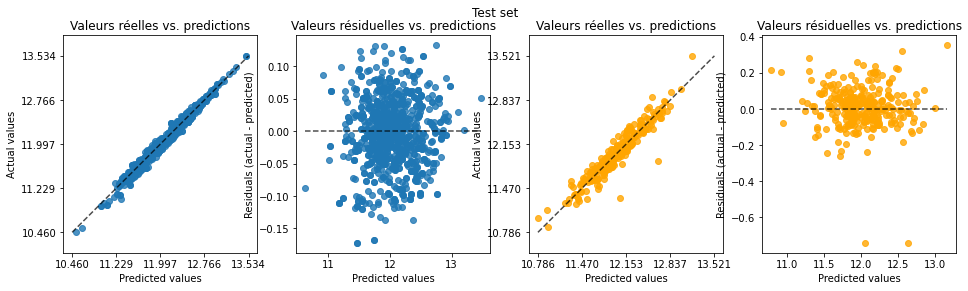

In [353]:
y_train_pred=GBoost.predict(X_train).squeeze()
y_test_pred=GBoost.predict(X_test).squeeze()
get_performance(y_train,y_train_pred,y_test,y_test_pred,metrics)

In [354]:
cv_results=cross_validate(GBoost,X_train,y_train,scoring=('r2','neg_mean_squared_error'),
                         error_score='raise',return_train_score=True)
pd.DataFrame(cv_results)

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  2.013424    0.028370  0.902616  0.984875                    -0.017841   
1  2.096370    0.023643  0.911910  0.985233                    -0.014740   
2  2.018903    0.033585  0.900533  0.986170                    -0.015898   
3  2.961544    0.035116  0.838386  0.987012                    -0.023610   
4  2.113631    0.022419  0.910556  0.985210                    -0.014682   

   train_neg_mean_squared_error  
0                     -0.002411  
1                     -0.002419  
2                     -0.002292  
3                     -0.002195  
4                     -0.002434

In [355]:
for score in ['r2','neg_mean_squared_error']:
    print(f"=={score}")
    for group in ['train','test']: 
        mean_score=cv_results[f"{group}_{score}"].mean()
        std_score=cv_results[f"{group}_{score}"].std()
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

==r2
train===================
 Mean score (std) 0.9857001820309801 (0.000784855939651551)

test===================
 Mean score (std) 0.8928001030463346 (0.027559016663417025)

==neg_mean_squared_error
train===================
 Mean score (std) -0.0023503908499042147 (9.291079380034761e-05)

test===================
 Mean score (std) -0.017354136368214125 (0.0033308499150665723)



#### Hyperparameters tuning

In [338]:
param_grid={'GBOOST__n_estimators':np.arange(250,280,1),
           "preprocessor__numerical__scaler":[StandardScaler(),MinMaxScaler()],
           "preprocessor__numerical__imputer__strategy": ["mean", "median"]}
grid_search=GridSearchCV(GBoost,param_grid,scoring=('r2','neg_mean_squared_error'),
                            cv=5,refit='neg_mean_squared_error',return_train_score=True)
grid_search

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        keep_empty_features=False,
                                                                                                        missing_values=na...
       276, 277, 278, 279]),
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median'],
                         'preprocessor__numerical__scaler': [StandardScaler(copy=True,
                                                                            with_mean=True,
                                                                            with_std=True),
                                                             MinMaxScaler(clip=False,
                                                                          copy=True,
                                                                          feature_range=(0,
                                                                                         1))]},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [339]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        keep_empty_features=False,
                                                                                                        missing_values=na...
       276, 277, 278, 279]),
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median'],
                         'preprocessor__numerical__scaler': [StandardScaler(copy=True,
                                                                            with_mean=True,
                                                                            with_std=True),
                                                             MinMaxScaler(clip=False,
                                                                          copy=True,
                                                                          feature_range=(0,
                                                                                         1))]},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [340]:
grid_search.best_params_

{'GBOOST__n_estimators': 278,
 'preprocessor__numerical__imputer__strategy': 'median',
 'preprocessor__numerical__scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [341]:
grid_cv_results=grid_search.cv_results_
best_param_index=np.where(grid_cv_results['rank_test_neg_mean_squared_error']==1)[0][0]
for score in ['r2','neg_mean_squared_error']:
    print (f"Best Scores: {score}")
    for group in ['train','test']:
        mean_score=grid_cv_results[f"mean_{group}_{score}"][best_param_index]
        std_score=grid_cv_results[f"std_{group}_{score}"][best_param_index]
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

Best Scores: r2
train===================
 Mean score (std) 0.9857001820309801 (0.000784855939651551)

test===================
 Mean score (std) 0.8942713190691478 (0.027218704489183194)

Best Scores: neg_mean_squared_error
train===================
 Mean score (std) -0.0023503908499042147 (9.291079380034761e-05)

test===================
 Mean score (std) -0.0171133912434159 (0.003283988451860927)



#### Features importance

Importance
OverallQual     0.388847
GrLivArea       0.171614
KitchenQual     0.071114
TotalBsmtSF     0.065837
GarageArea      0.025483
GarageFinish    0.023822
BsmtQual        0.023278
GarageCars      0.022728

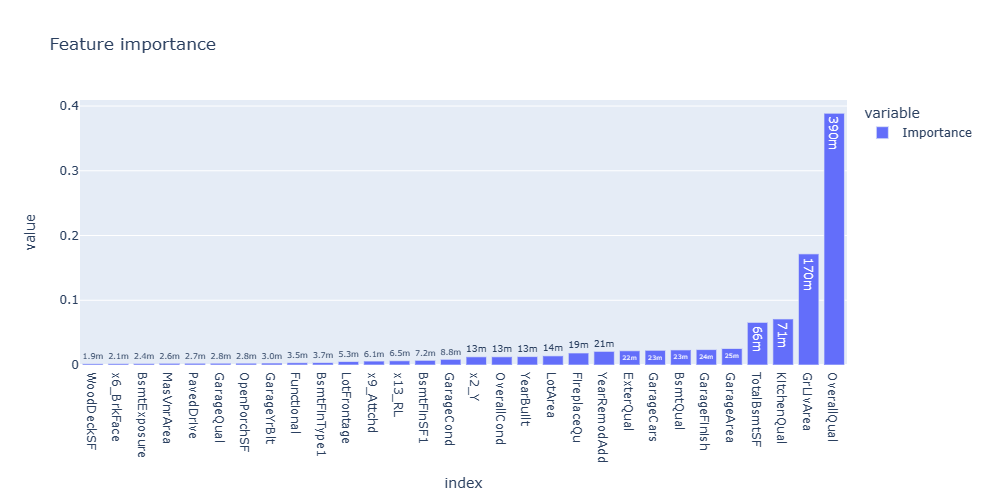

In [77]:
feature_importance=pd.DataFrame(GBoost['GBOOST'].feature_importances_,index=model_features,columns=['Importance'])
"""
Plot feature importances
"""
display(feature_importance.nlargest(8,'Importance'))
pd.options.plotting.backend = "plotly"
(feature_importance
    .sort_values('Importance',ascending=True)
    .tail(30)
    .plot.bar(title='Feature importance',text_auto='.2s',height=500)
    )

In [357]:
explainer=shap.TreeExplainer(GBoost['GBOOST'],feature_names=model_features)
shap_values=explainer.shap_values(preprocessor.transform(X_train),y_train)
expected_value=explainer.expected_value[0]

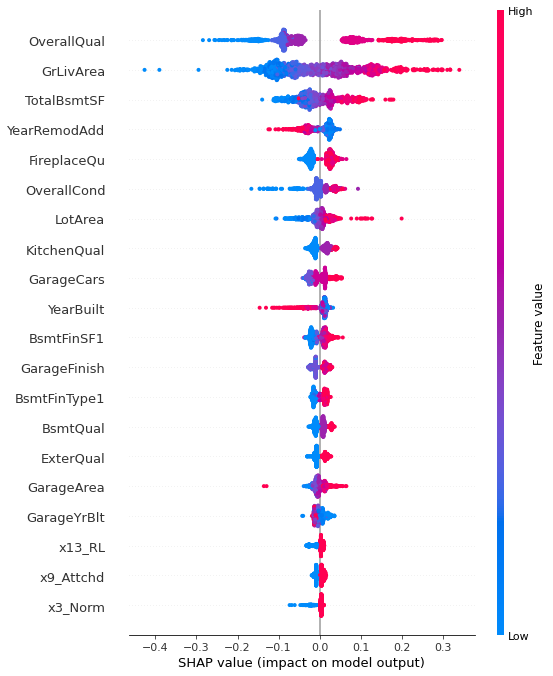

In [358]:
shap.summary_plot(shap_values,preprocessor.transform(X_train),feature_names=model_features)

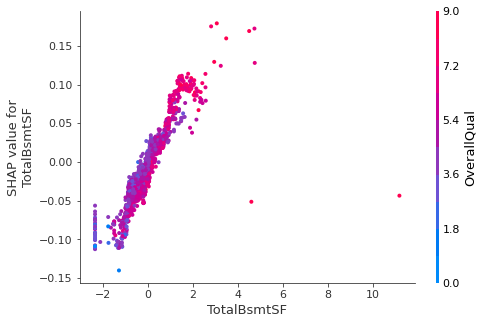

In [359]:
shap.dependence_plot('TotalBsmtSF',shap_values,preprocessor.transform(X_train),feature_names=model_features)

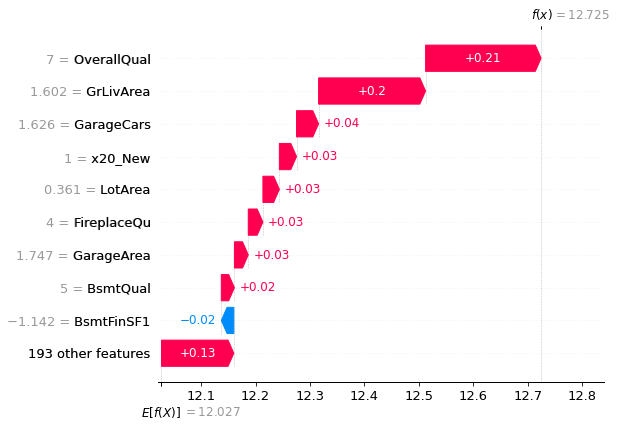

In [364]:
shap.plots._waterfall.waterfall_legacy(expected_value,shap_values[0,:],preprocessor.transform(X_train)[0,:],feature_names=model_features)

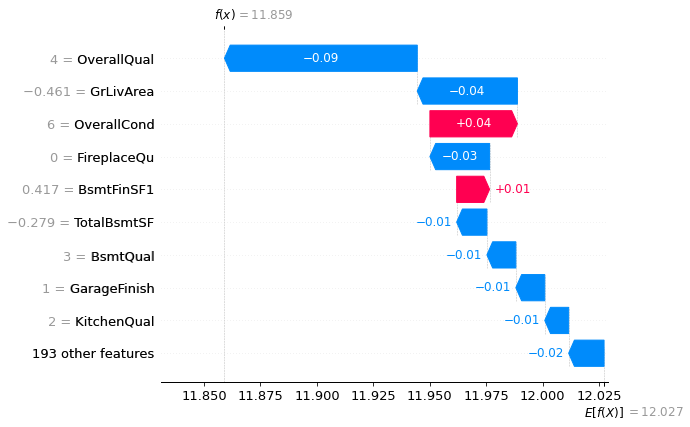

In [366]:
shap.plots._waterfall.waterfall_legacy(expected_value,shap_values[2,:],preprocessor.transform(X_train)[2,:],feature_names=model_features)

In [367]:
shap.initjs()
shap.force_plot(expected_value,shap_values[0,:],preprocessor.transform(X_train)[0,:],feature_names=model_features)

### LightGBM

In [78]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                      ("scaler", MinMaxScaler())]
                                  )

categorical_transformer = Pipeline(steps=[("imputer",SimpleImputer(strategy="constant", fill_value="missing")),
                                          ("OHE",OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False))]
                                    )
ordinal_transformer = Pipeline(steps=[('imputer2',SimpleImputer(strategy="constant")),
                                          ('ORD_ENC',OrdinalEncoder(categories=ordinal_categories,handle_unknown='error'))]
)
preprocessor=ColumnTransformer(
    transformers=[
            ('numerical',numeric_transformer,make_column_selector(dtype_include='number')),
            ('nominal',categorical_transformer,nominal_features),
            ('ordinal',ordinal_transformer,ordinal_features)
    ]
)

In [79]:
lightGBM=Pipeline(
    steps=[('preprocessor',preprocessor),('LGBM',LGBMRegressor(num_leaves=13))]
)

In [80]:
lightGBM.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  (...
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, importance_type='split',
                               learning_rate=0.1, max_depth=-1,
                               min_child_samples=20, min_child_weight=0.001,
                               min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                               num_leaves=13, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                               subsample=1.0, subsample_for_bin=200000,
                               subsample_freq=0))],
         verbose=False)

metric     train      test
0                        r2_score  0.971451  0.880687
1              mean_squared_error  0.004529  0.019409
2             mean_absolute_error  0.047647  0.092320
3                       max_error  0.489795  0.930673
4           median_absolute_error  0.036497  0.067224
5  mean_absolute_percentage_error  0.003987  0.007713

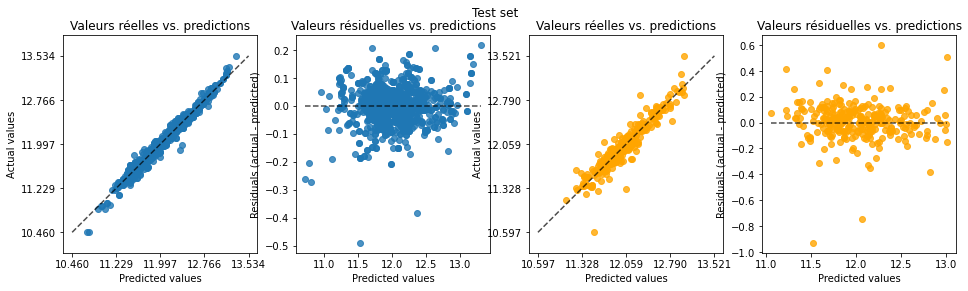

In [81]:
y_train_pred=lightGBM.predict(X_train).squeeze()
y_test_pred=lightGBM.predict(X_test).squeeze()
get_performance(y_train,y_train_pred,y_test,y_test_pred,metrics)

In [420]:
cv_results=cross_validate(lightGBM,X_train,y_train,scoring=('r2','neg_mean_squared_error'),
                     error_score='raise',return_train_score=True,cv=5)
pd.DataFrame(cv_results)

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.215449    0.022317  0.907413  0.972919                    -0.016962   
1  0.205620    0.024307  0.888315  0.973884                    -0.018688   
2  0.202286    0.022058  0.898511  0.975770                    -0.016221   
3  0.234218    0.026654  0.840465  0.976831                    -0.023307   
4  0.210421    0.023144  0.907833  0.973479                    -0.015129   

   train_neg_mean_squared_error  
0                     -0.004318  
1                     -0.004279  
2                     -0.004015  
3                     -0.003915  
4                     -0.004365

In [421]:
for score in ['r2','neg_mean_squared_error']:
    print(f"=={score}")
    for group in ['train','test']: 
        mean_score=cv_results[f"{group}_{score}"].mean()
        std_score=cv_results[f"{group}_{score}"].std()
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

==r2
train===================
 Mean score (std) 0.9745765835271228 (0.001479178982649629)

test===================
 Mean score (std) 0.8885072835849034 (0.02505620052249205)

==neg_mean_squared_error
train===================
 Mean score (std) -0.00417853311870703 (0.00017902473210294005)

test===================
 Mean score (std) -0.01806127532802883 (0.002867039983683381)



#### Hyperparameters tuning

In [414]:
param_grid={'LGBM__num_leaves':np.arange(7,25,1),
           "preprocessor__numerical__scaler":[StandardScaler(),MinMaxScaler()],
           "preprocessor__numerical__imputer__strategy": ["mean", "median"]}
grid_search=GridSearchCV(lightGBM,param_grid,scoring=('r2','neg_mean_squared_error'),
                            cv=5,refit='neg_mean_squared_error',return_train_score=True)
grid_search

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        keep_empty_features=False,
                                                                                                        missing_values=na...
             param_grid={'LGBM__num_leaves': array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24]),
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median'],
                         'preprocessor__numerical__scaler': [StandardScaler(copy=True,
                                                                            with_mean=True,
                                                                            with_std=True),
                                                             MinMaxScaler(clip=False,
                                                                          copy=True,
                                                                          feature_range=(0,
                                                                                         1))]},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [415]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        keep_empty_features=False,
                                                                                                        missing_values=na...
             param_grid={'LGBM__num_leaves': array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24]),
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median'],
                         'preprocessor__numerical__scaler': [StandardScaler(copy=True,
                                                                            with_mean=True,
                                                                            with_std=True),
                                                             MinMaxScaler(clip=False,
                                                                          copy=True,
                                                                          feature_range=(0,
                                                                                         1))]},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [416]:
grid_search.best_params_

{'LGBM__num_leaves': 13,
 'preprocessor__numerical__imputer__strategy': 'median',
 'preprocessor__numerical__scaler': MinMaxScaler(clip=False, copy=True, feature_range=(0, 1))}

In [413]:
grid_cv_results=grid_search.cv_results_
best_param_index=np.where(grid_cv_results['rank_test_neg_mean_squared_error']==1)[0][0]
for score in ['r2','neg_mean_squared_error']:
    print (f"Best Scores: {score}")
    for group in ['train','test']:
        mean_score=grid_cv_results[f"mean_{group}_{score}"][best_param_index]
        std_score=grid_cv_results[f"std_{group}_{score}"][best_param_index]
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

Best Scores: r2
train===================
 Mean score (std) 0.9745765835271228 (0.001479178982649629)

test===================
 Mean score (std) 0.8885072835849034 (0.02505620052249205)

Best Scores: neg_mean_squared_error
train===================
 Mean score (std) -0.00417853311870703 (0.00017902473210294005)

test===================
 Mean score (std) -0.01806127532802883 (0.002867039983683381)



#### Features importance

<AxesSubplot:>

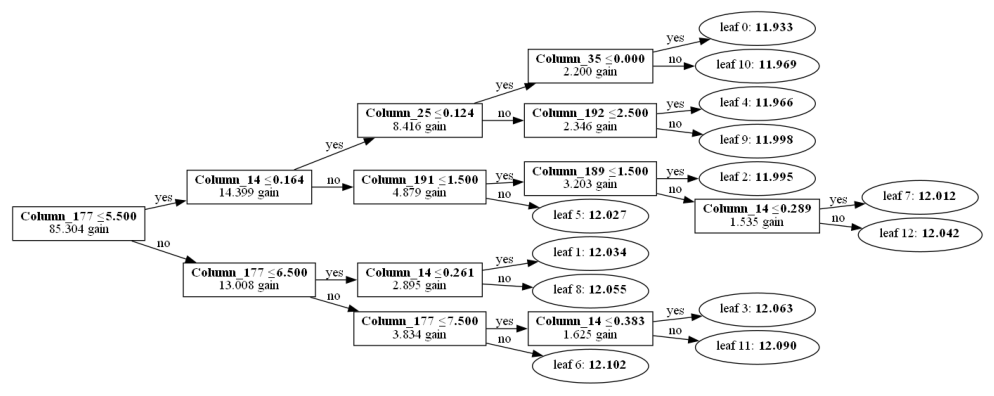

In [82]:
plot_tree(lightGBM['LGBM'],figsize=(14,8),dpi=90,show_info=['split_gain'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

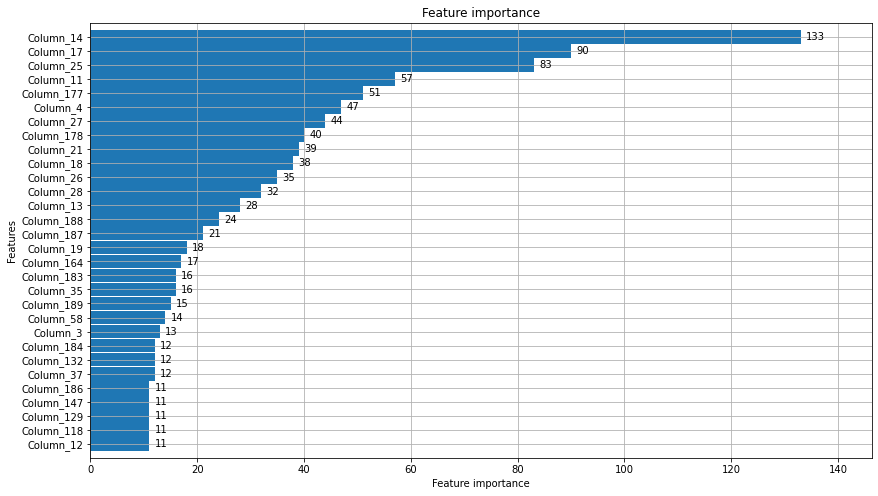

In [83]:
plot_importance(lightGBM['LGBM'],max_num_features=30,height=0.98,figsize=(14,8),importance_type='split')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

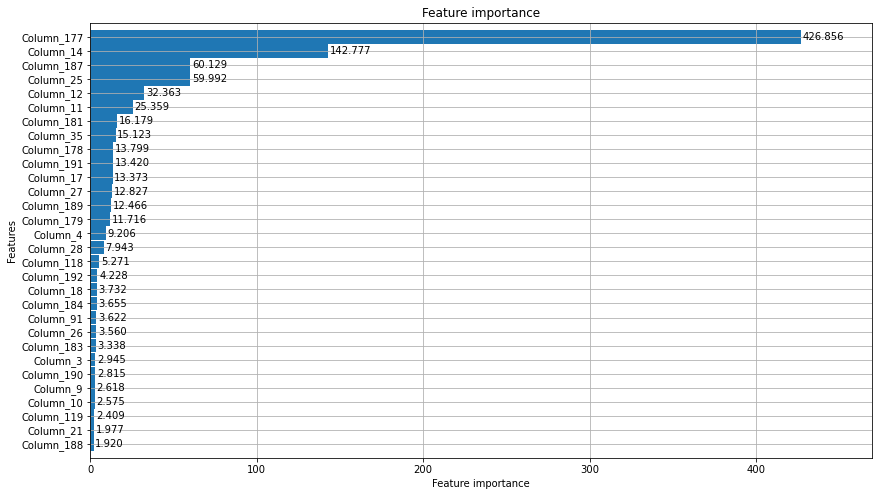

In [84]:
plot_importance(lightGBM['LGBM'],max_num_features=30,height=0.98,figsize=(14,8),importance_type='gain')

In [85]:
explainer=shap.TreeExplainer(lightGBM['LGBM'],feature_names=model_features)
shap_values=explainer.shap_values(preprocessor.transform(X_train),y_train)
expected_value=explainer.expected_value

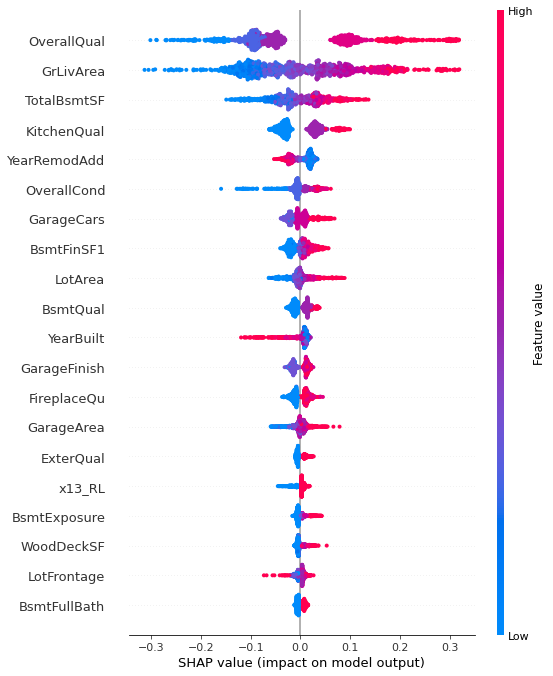

In [86]:
shap.summary_plot(shap_values,preprocessor.transform(X_train),feature_names=model_features)

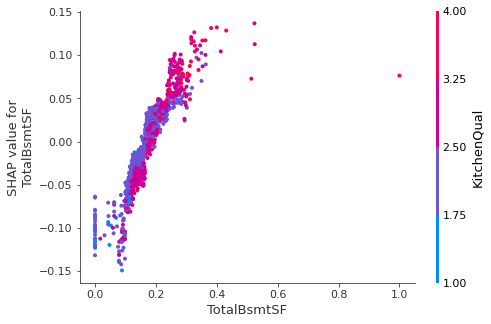

In [87]:
shap.dependence_plot('TotalBsmtSF',shap_values,preprocessor.transform(X_train),feature_names=model_features)

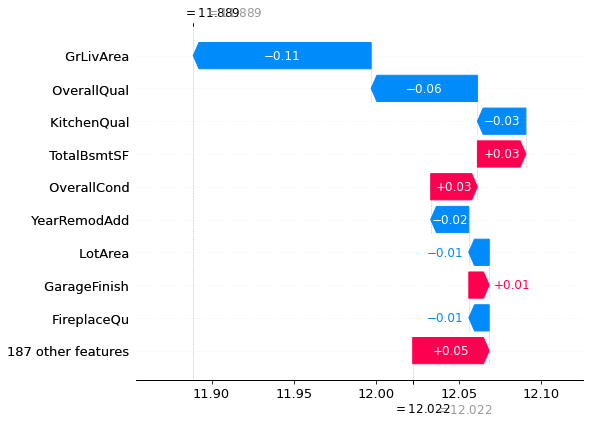

In [88]:
shap.plots._waterfall.waterfall_legacy(expected_value,shap_values[0,:],preprocessor.transform(X_train)[0,:],feature_names=model_features)

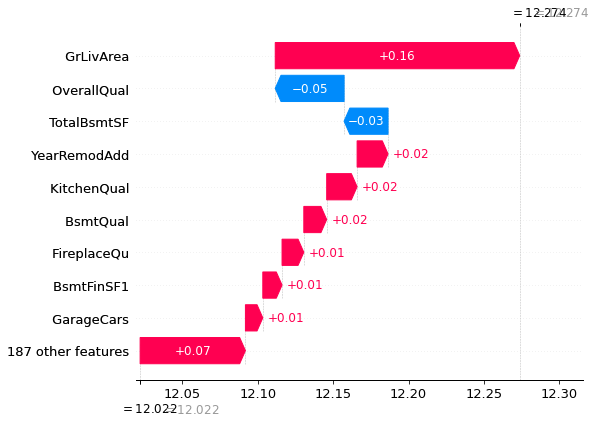

In [89]:
shap.plots._waterfall.waterfall_legacy(expected_value,shap_values[1,:],preprocessor.transform(X_train)[1,:],feature_names=model_features)

In [90]:
shap.initjs()
shap.force_plot(expected_value,shap_values[0,:],preprocessor.transform(X_train)[0,:],feature_names=model_features)

### CatBoost

In [91]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                      ("scaler", MinMaxScaler())]
                                  )

categorical_transformer = Pipeline(steps=[("imputer",SimpleImputer(strategy="constant", fill_value="missing")),
                                          ("OHE",OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False))]
                                    )
ordinal_transformer = Pipeline(steps=[('imputer2',SimpleImputer(strategy="constant")),
                                          ('ORD_ENC',OrdinalEncoder(categories=ordinal_categories,handle_unknown='error'))]
)
preprocessor=ColumnTransformer(
    transformers=[
            ('numerical',numeric_transformer,make_column_selector(dtype_include='number')),
            ('nominal',categorical_transformer,nominal_features),
            ('ordinal',ordinal_transformer,ordinal_features)
    ]
)

In [92]:
catBoost=Pipeline(
                steps=[('preprocessor',preprocessor),
                       ('CATBOOST',CatBoostRegressor(iterations=362,verbose=0))]
)
catBoost

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  (...
                                                   'OverallCond', 'ExterQual',
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu', 'GarageQual',
                                                   'GarageFinish', 'GarageCond',
                                                   'PavedDrive', 'PoolQC',
                                                   'Fence'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('CATBOOST',
                 <catboost.core.CatBoostRegressor object at 0x000002253C646430>)],
         verbose=False)

In [93]:
catBoost.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  (...
                                                   'OverallCond', 'ExterQual',
                                                   'ExterCond', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'Functional',
                                                   'FireplaceQu', 'GarageQual',
                                                   'GarageFinish', 'GarageCond',
                                                   'PavedDrive', 'PoolQC',
                                                   'Fence'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('CATBOOST',
                 <catboost.core.CatBoostRegressor object at 0x000002253C646430>)],
         verbose=False)

metric     train      test
0                        r2_score  0.988417  0.913204
1              mean_squared_error  0.001906  0.012055
2             mean_absolute_error  0.034157  0.074302
3                       max_error  0.227285  0.740922
4           median_absolute_error  0.027585  0.058263
5  mean_absolute_percentage_error  0.002851  0.006194

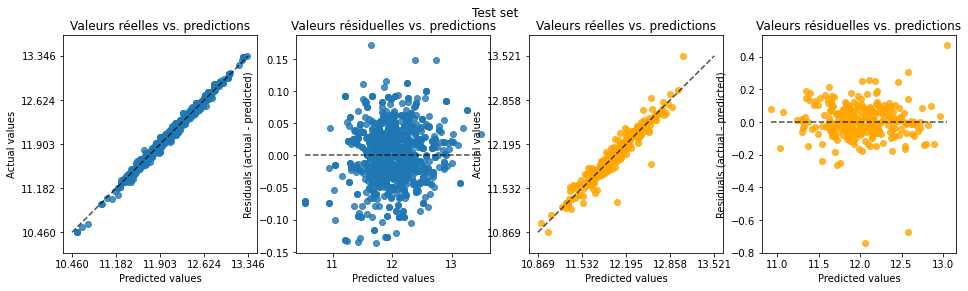

In [454]:
y_train_pred=catBoost.predict(X_train).squeeze()
y_test_pred=catBoost.predict(X_test).squeeze()
get_performance(y_train,y_train_pred,y_test,y_test_pred,metrics)

In [455]:
cv_results=cross_validate(catBoost,X_train,y_train,scoring=('r2','neg_mean_squared_error'),
                          cv=5,error_score='raise',return_train_score=True)
pd.DataFrame(cv_results)

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  1.909616    0.033566  0.898592  0.989750                    -0.018578   
1  1.835465    0.034041  0.902217  0.988943                    -0.016362   
2  1.864360    0.033079  0.909123  0.991515                    -0.014525   
3  1.800283    0.033219  0.865374  0.991921                    -0.019668   
4  1.833465    0.034775  0.923231  0.990569                    -0.012601   

   train_neg_mean_squared_error  
0                     -0.001634  
1                     -0.001812  
2                     -0.001406  
3                     -0.001365  
4                     -0.001552

In [456]:
for score in ['r2','neg_mean_squared_error']:
    print(f"=={score}")
    for group in ['train','test']: 
        mean_score=cv_results[f"{group}_{score}"].mean()
        std_score=cv_results[f"{group}_{score}"].std()
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

==r2
train===================
 Mean score (std) 0.9905397267556826 (0.0010983737016485617)

test===================
 Mean score (std) 0.8997073746040127 (0.019122717318658618)

==neg_mean_squared_error
train===================
 Mean score (std) -0.0015538932094114302 (0.00016141819796718613)

test===================
 Mean score (std) -0.016346713662394503 (0.0025829020309363453)



#### Hyperparameters tuning

In [457]:
param_grid={'CATBOOST__iterations':np.arange(350,375,1),
            "preprocessor__numerical__scaler":[StandardScaler(),MinMaxScaler()],
           "preprocessor__numerical__imputer__strategy": ["mean", "median"]}
grid_search=GridSearchCV(catBoost,param_grid,scoring=('r2','neg_mean_squared_error'),
                            cv=5,refit='neg_mean_squared_error',return_train_score=True)
grid_search

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        keep_empty_features=False,
                                                                                                        missing_values=na...
       363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]),
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median'],
                         'preprocessor__numerical__scaler': [StandardScaler(copy=True,
                                                                            with_mean=True,
                                                                            with_std=True),
                                                             MinMaxScaler(clip=False,
                                                                          copy=True,
                                                                          feature_range=(0,
                                                                                         1))]},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [449]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        keep_empty_features=False,
                                                                                                        missing_values=na...
       363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]),
                         'preprocessor__numerical__imputer__strategy': ['mean',
                                                                        'median'],
                         'preprocessor__numerical__scaler': [StandardScaler(copy=True,
                                                                            with_mean=True,
                                                                            with_std=True),
                                                             MinMaxScaler(clip=False,
                                                                          copy=True,
                                                                          feature_range=(0,
                                                                                         1))]},
             pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
             return_train_score=True, scoring=('r2', 'neg_mean_squared_error'),
             verbose=0)

In [450]:
best_params=grid_search.best_params_
print(f"Best params : {best_params}")

Best params : {'CATBOOST__iterations': 362, 'preprocessor__numerical__imputer__strategy': 'median', 'preprocessor__numerical__scaler': MinMaxScaler(clip=False, copy=True, feature_range=(0, 1))}


In [458]:
grid_cv_results=grid_search.cv_results_
best_param_index=np.where(grid_cv_results['rank_test_neg_mean_squared_error']==1)[0][0]
for score in ['r2','neg_mean_squared_error']:
    print (f"Best Scores: {score}")
    for group in ['train','test']:
        mean_score=grid_cv_results[f"mean_{group}_{score}"][best_param_index]
        std_score=grid_cv_results[f"std_{group}_{score}"][best_param_index]
        print(f"{group}===================\n Mean score (std) {mean_score} ({std_score})\n")

AttributeError: ignored

#### Features importances

In [94]:
def get_input_features(model_pipeline):
    
    """ Get model feature names used in training
    """
    all_feature_names = []

    for step_name, pipe_trans, feat_names in model_pipeline["preprocessor"].transformers_:
        if step_name == "nominal":
            all_feature_names.extend(pipe_trans
                                     .get_feature_names_out()
                                    )
        else:
            all_feature_names.extend(feat_names)
    
    return all_feature_names

In [95]:
model_features=get_input_features(catBoost)

Importances
Feature Id              
OverallQual    16.441281
GrLivArea      16.325478
TotalBsmtSF     8.139195
KitchenQual     5.550799
LotArea         3.406517
ExterQual       3.127023
BsmtQual        2.821052
OverallCond     2.474415

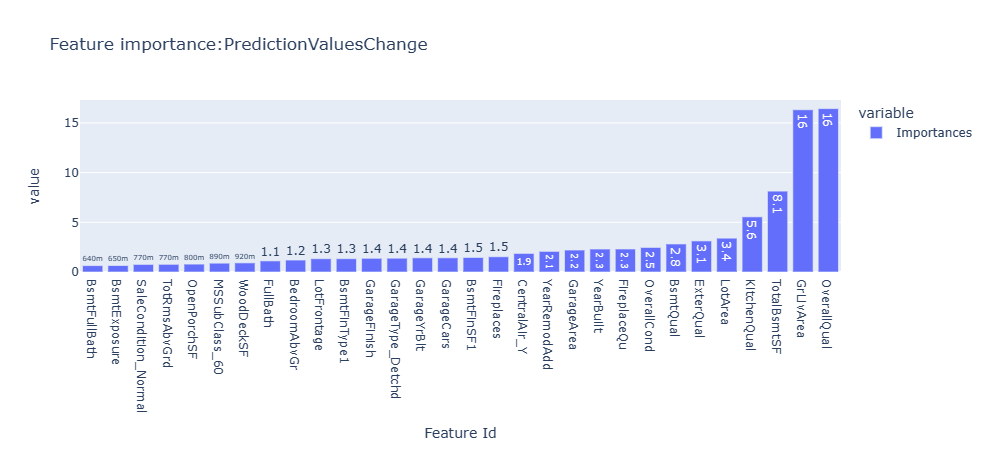

In [96]:
train_pool=Pool(data=preprocessor.transform(X_train),label=y_train,feature_names=model_features)

def feature_importance(pool_data=train_pool,type='PredictionValuesChange',top=30):
    feature_importance=catBoost.named_steps['CATBOOST'].get_feature_importance(pool_data,
                                                                               type,prettified=True)
    
    if type in ['PredictionValuesChange','LossFunctionChange']:
        feature_importance.set_index('Feature Id',inplace=True)
        value='Importances'
    else :
        feature_importance=feature_importance.astype({'First Feature Index':'object','Second Feature Index':'object'})
        feature_importance['Features Id'] = " ".join([feature_importance['First Feature Index'], feature_importance['Second Feature Index']])
        feature_importance.drop(['First Feature Index','Second Feature Index'],axis=1,inplace=True)
        feature_importance.set_index('Features Id',inplace=True)
        value='Interaction'
        
        
    display(feature_importance.head(8))
    """
    Plot features importances
    """
    pd.options.plotting.backend = "plotly"
    return (feature_importance
     .sort_values(value,key=lambda v:abs(v),ascending=True)
     .tail(30)
     .plot.bar(title=f'Feature importance:{type}',text_auto='.2s',height=450)
    )


feature_importance()

Importances
Feature Id               
GrLivArea        0.063165
OverallQual      0.039287
TotalBsmtSF      0.033521
KitchenQual      0.012253
LotArea          0.011361
OverallCond      0.009414
YearRemodAdd     0.006720
YearBuilt        0.006459

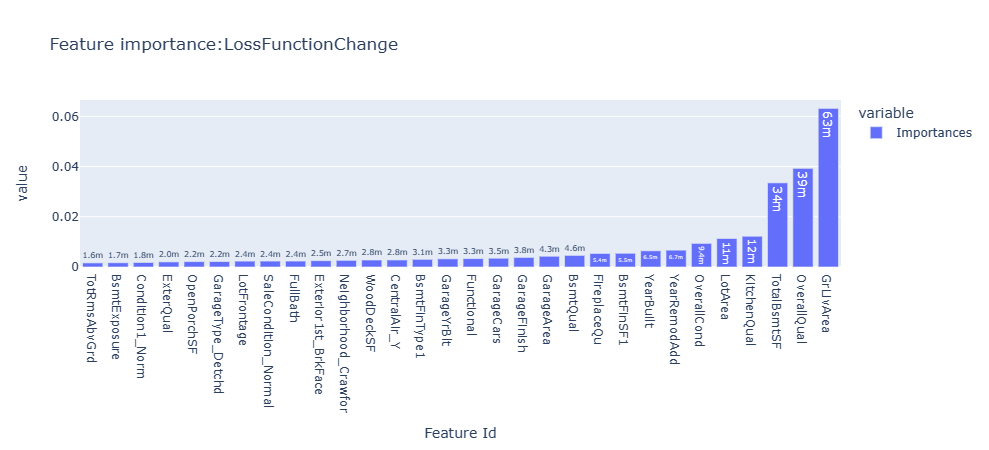

In [97]:
feature_importance(pool_data=train_pool,type='LossFunctionChange')

In [ ]:
#feature_importance(pool_data=train_pool,type='Interaction')

TypeError: sequence item 0: expected str instance, Series found

In [98]:
shap_values=catBoost.named_steps['CATBOOST'].get_feature_importance(train_pool,'ShapValues')

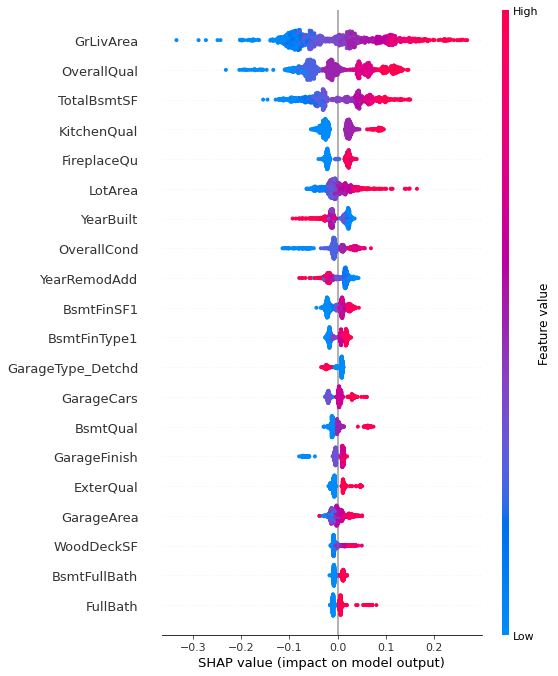

In [99]:
shap.summary_plot(shap_values[:,:-1],preprocessor.transform(X_train),feature_names=model_features)

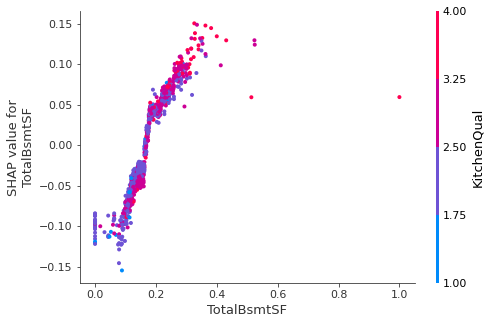

In [100]:
shap.dependence_plot('TotalBsmtSF',shap_values[:,:-1],preprocessor.transform(X_train),feature_names=model_features)

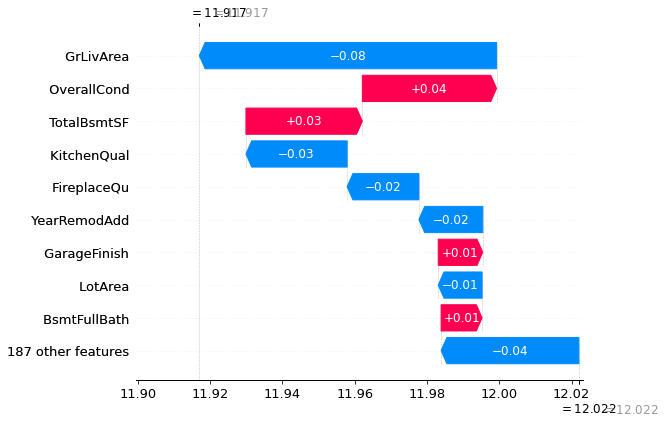

In [101]:
shap.plots._waterfall.waterfall_legacy(shap_values[0,-1],shap_values[0,:-1],preprocessor.transform(X_train)[0,:],feature_names=model_features)

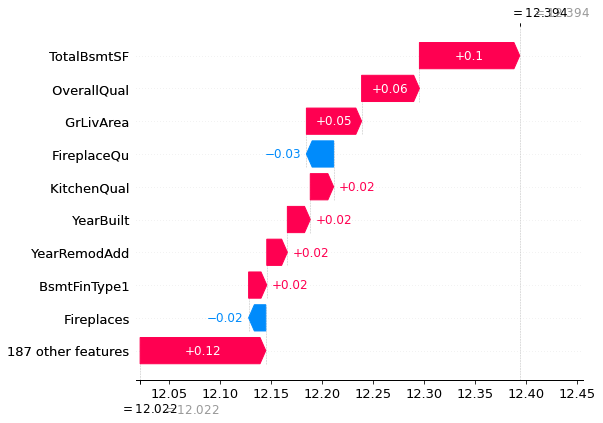

In [102]:
shap.plots._waterfall.waterfall_legacy(shap_values[9,-1],shap_values[9,:-1],preprocessor.transform(X_train)[9,:],feature_names=model_features)

In [103]:
shap.initjs()
shap.force_plot(shap_values[0,-1],shap_values[0,:-1],preprocessor.transform(X_train)[0,:],feature_names=model_features)